# Case study: CPA-catalyzed nucleophilic addition to imines (*Nature* **2019**)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
from MT_utils import run_MT, get_sorted_neighbours, run_and_plot

import sys
sys.path.append('../../src/')
import RaRFRegressor
import utils

plt.rcParams['font.size'] = 14
COLORA = '#027F80'
COLORB = '#B2E5FC'

SEED = 314159


## RaRF Regression

In [48]:

# uploading data
df1 = pd.read_excel('../../data/Chem_Sci_2024.xlsx', sheet_name=None)
df2 = pd.read_excel('../../data/Chem_Sci_2024.xlsx', sheet_name='SM_SMILES')
df3 = df1['pivoted'].iloc[:, [0,1,6]].dropna()

ddG = df3['ddG']

starting_materials = {df2['substrate_name'][i]: utils.smi2morgan(df2['substrate_smiles'][i])
                      for i in range(np.size(df2['substrate_name']))}

starting_materials_reactions = []
for sm in df3['Substrate']:
    starting_materials_reactions.append(starting_materials[sm])

ligands_raw = df1['Ligands'].iloc[:, [0, 6]].dropna()
ligands_raw = ligands_raw.dropna()
converted_smiles = [utils.remove_metal_bonds(lig,'Fe') for lig in ligands_raw['Canonical SMILES']]
ligands = {ligands_raw['Ligand'].iloc[i]: utils.smi2morgan(converted_smiles[i])
           for i in range(np.size(converted_smiles))}

ligands_reactions =[]
for l in df3['Ligand#']:
    ligands_reactions.append(ligands[l])

# fingerprints of reactions

reactions = np.column_stack((ddG, starting_materials_reactions, ligands_reactions))

In [49]:
reactions

array([[ 0.43021033,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02390057,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54971319,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.28680688,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.86042065,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11950287,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [50]:
# Only include the DDG and the fingerprint bits in df.iloc[:,6:]
reduced_df = VarianceThreshold().fit_transform(reactions)

# before this, I really
df_train, df_test = train_test_split(reduced_df,train_size=0.8, random_state=25)

X_train = df_train[:,1:]
X_test = df_test[:,1:]
y_train = df_train[:,0]
y_test = df_test[:,0]

/home/roy/Documents/rarfviz /cs5c01051_si_002/repo/Tests_1/MT Notebooks/MT_utils.py:47: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


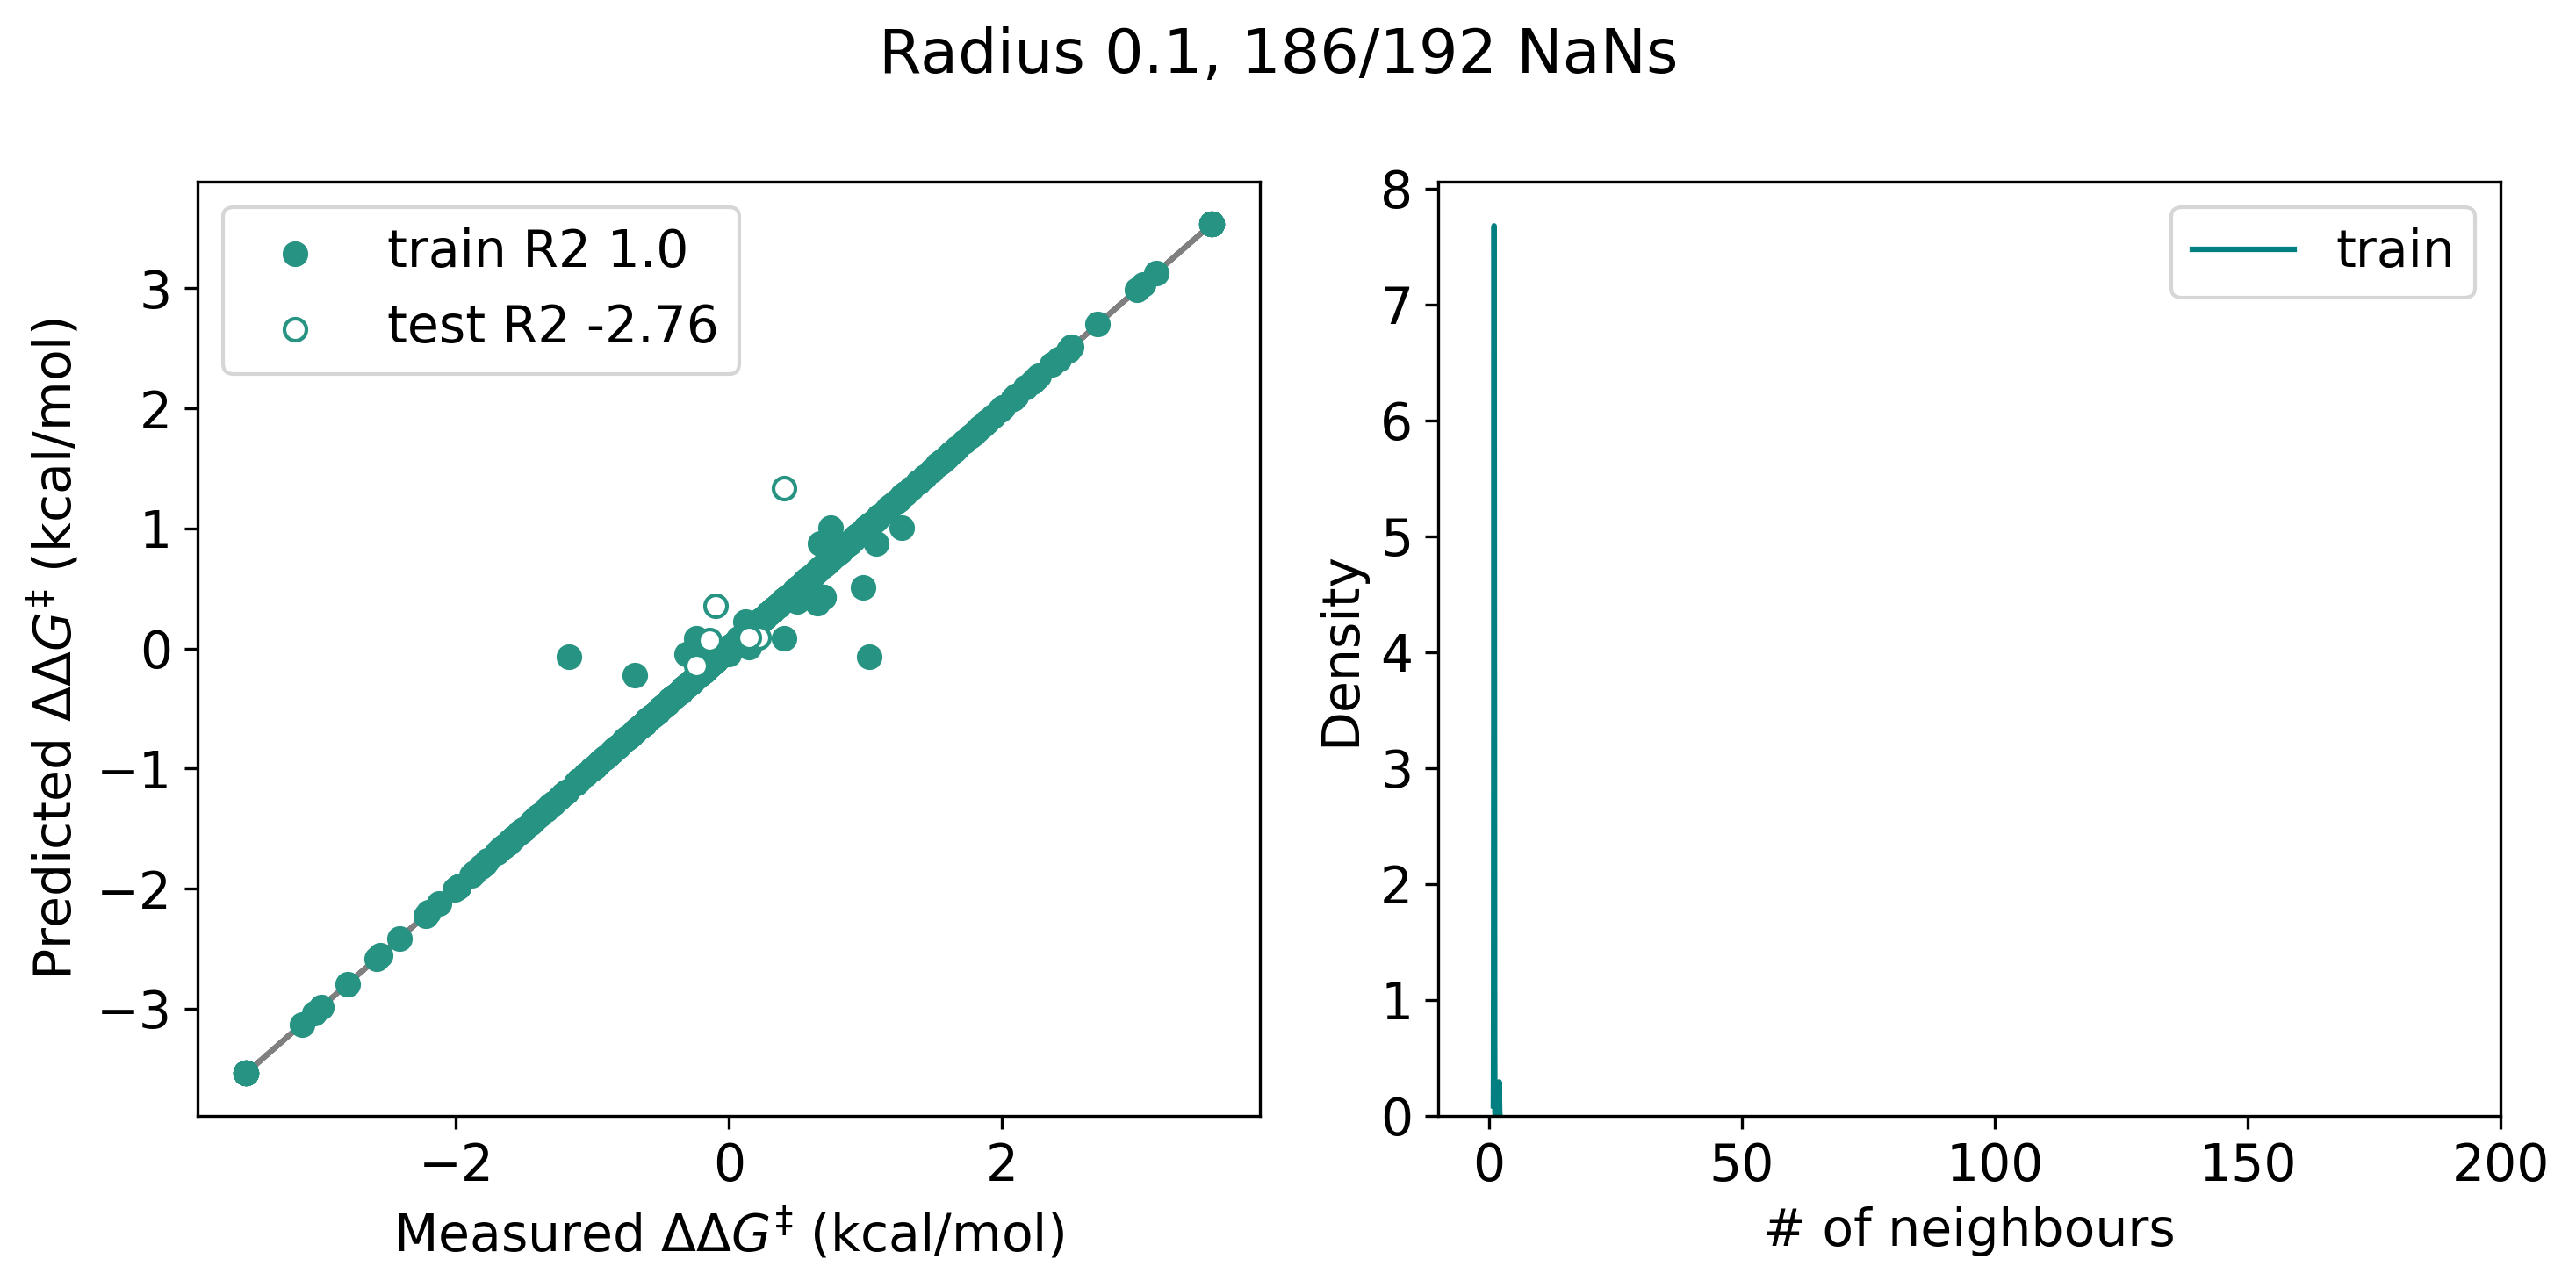

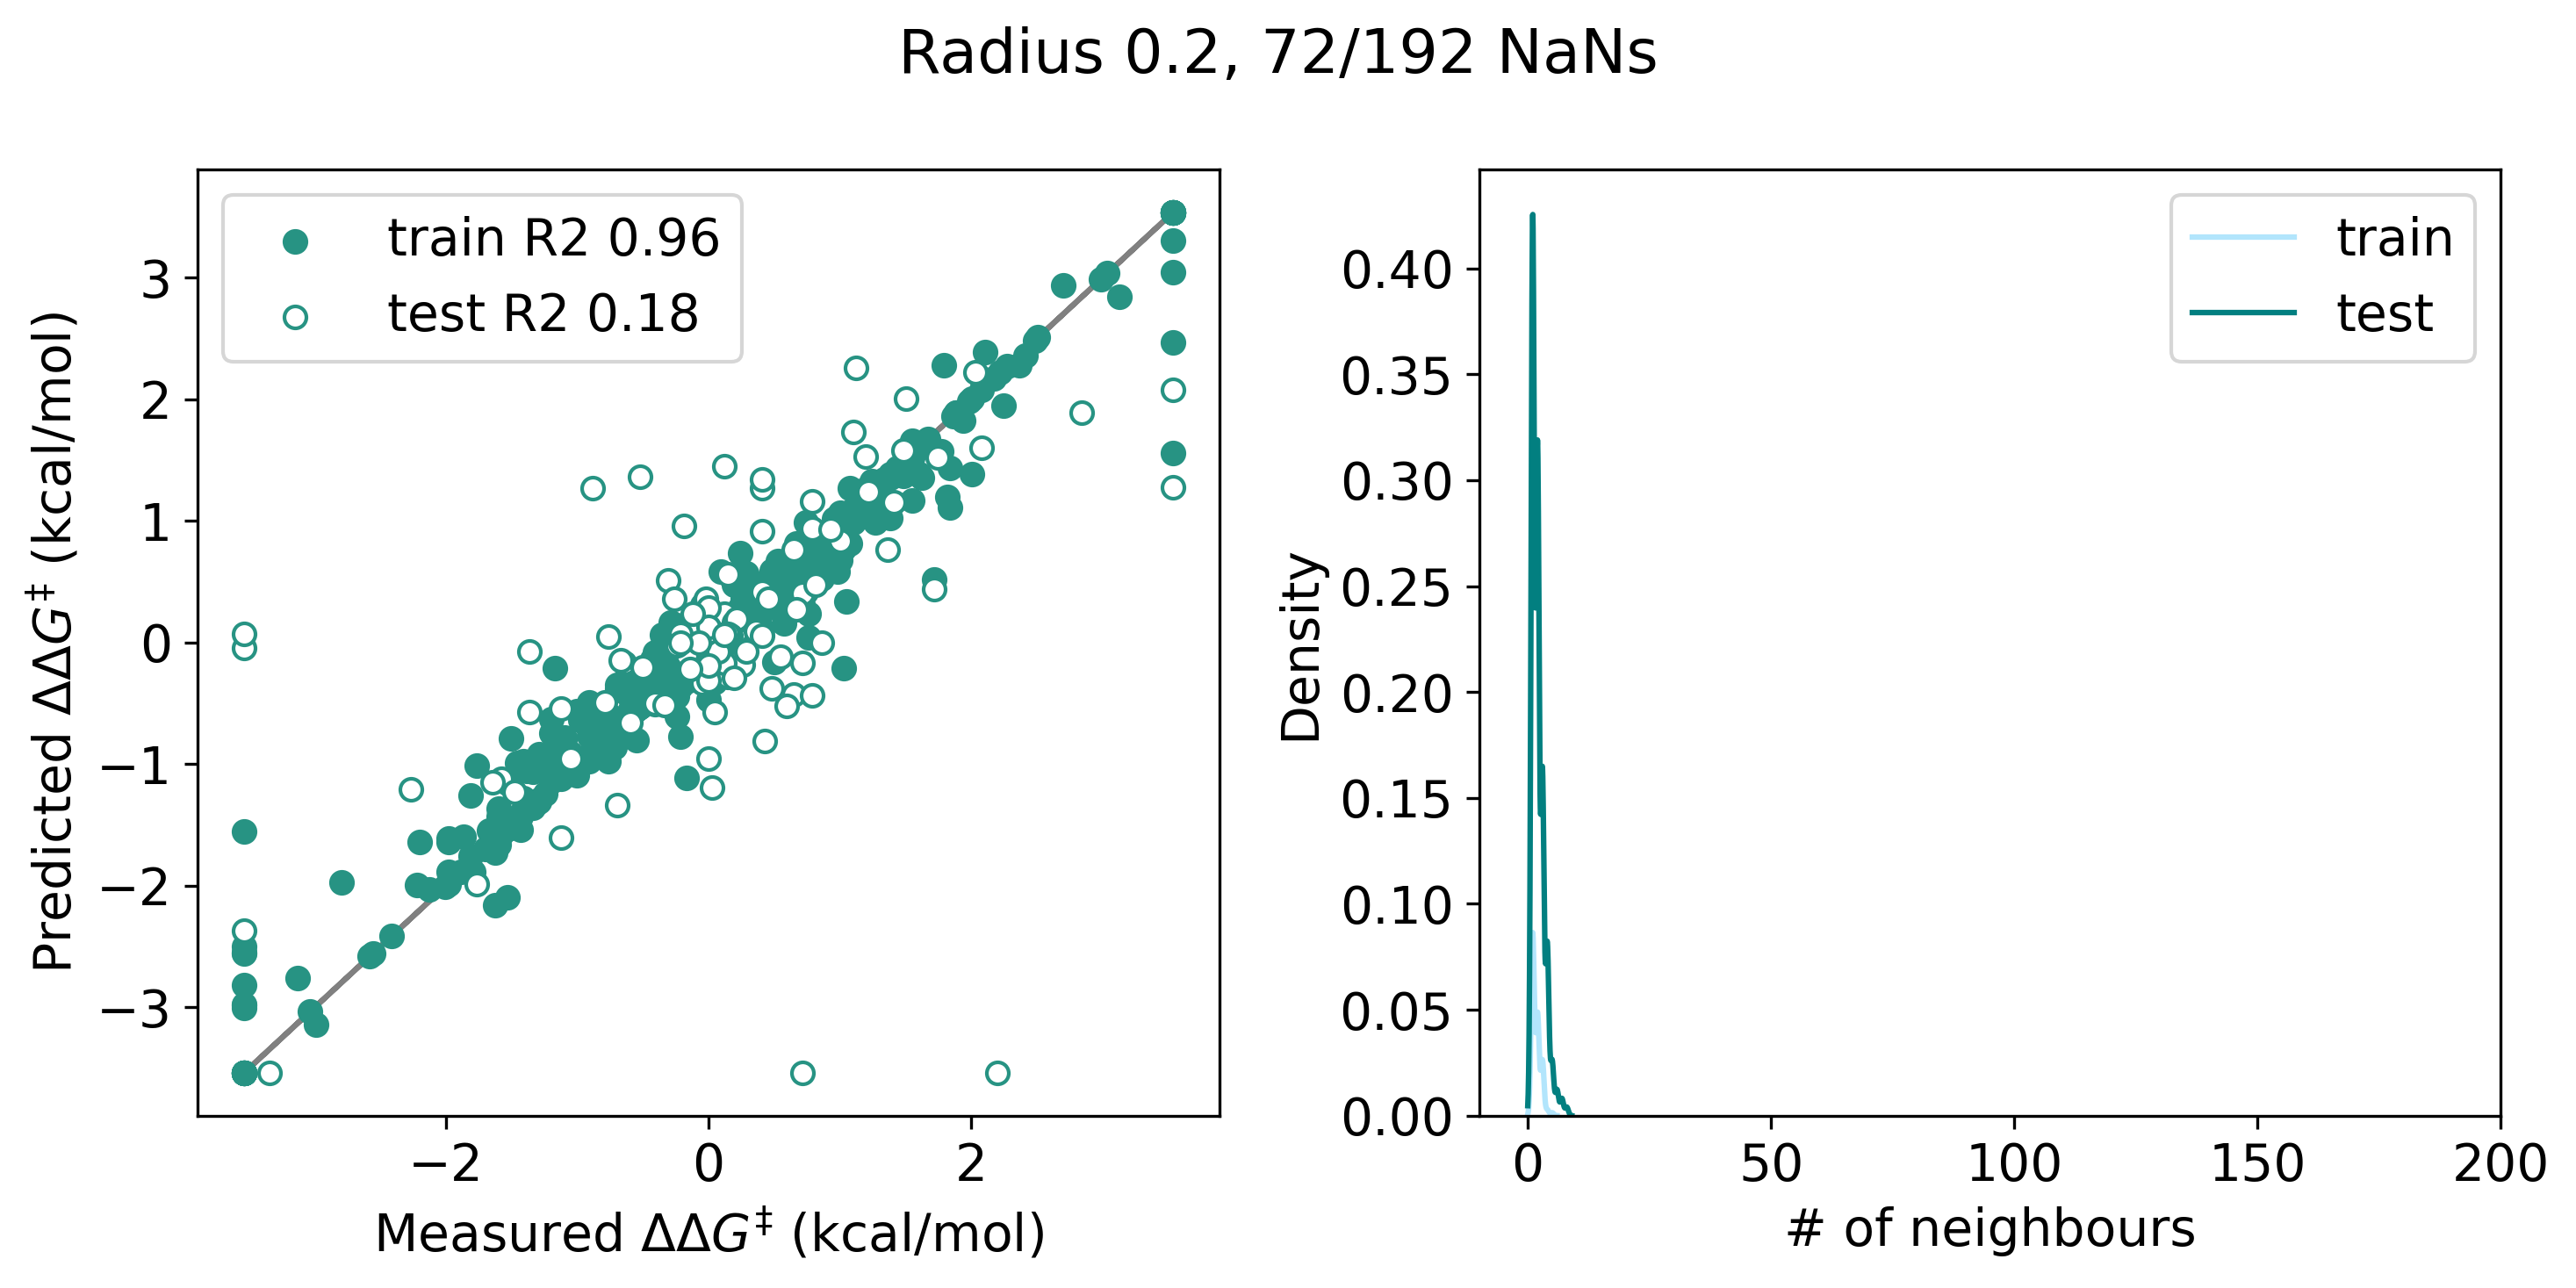

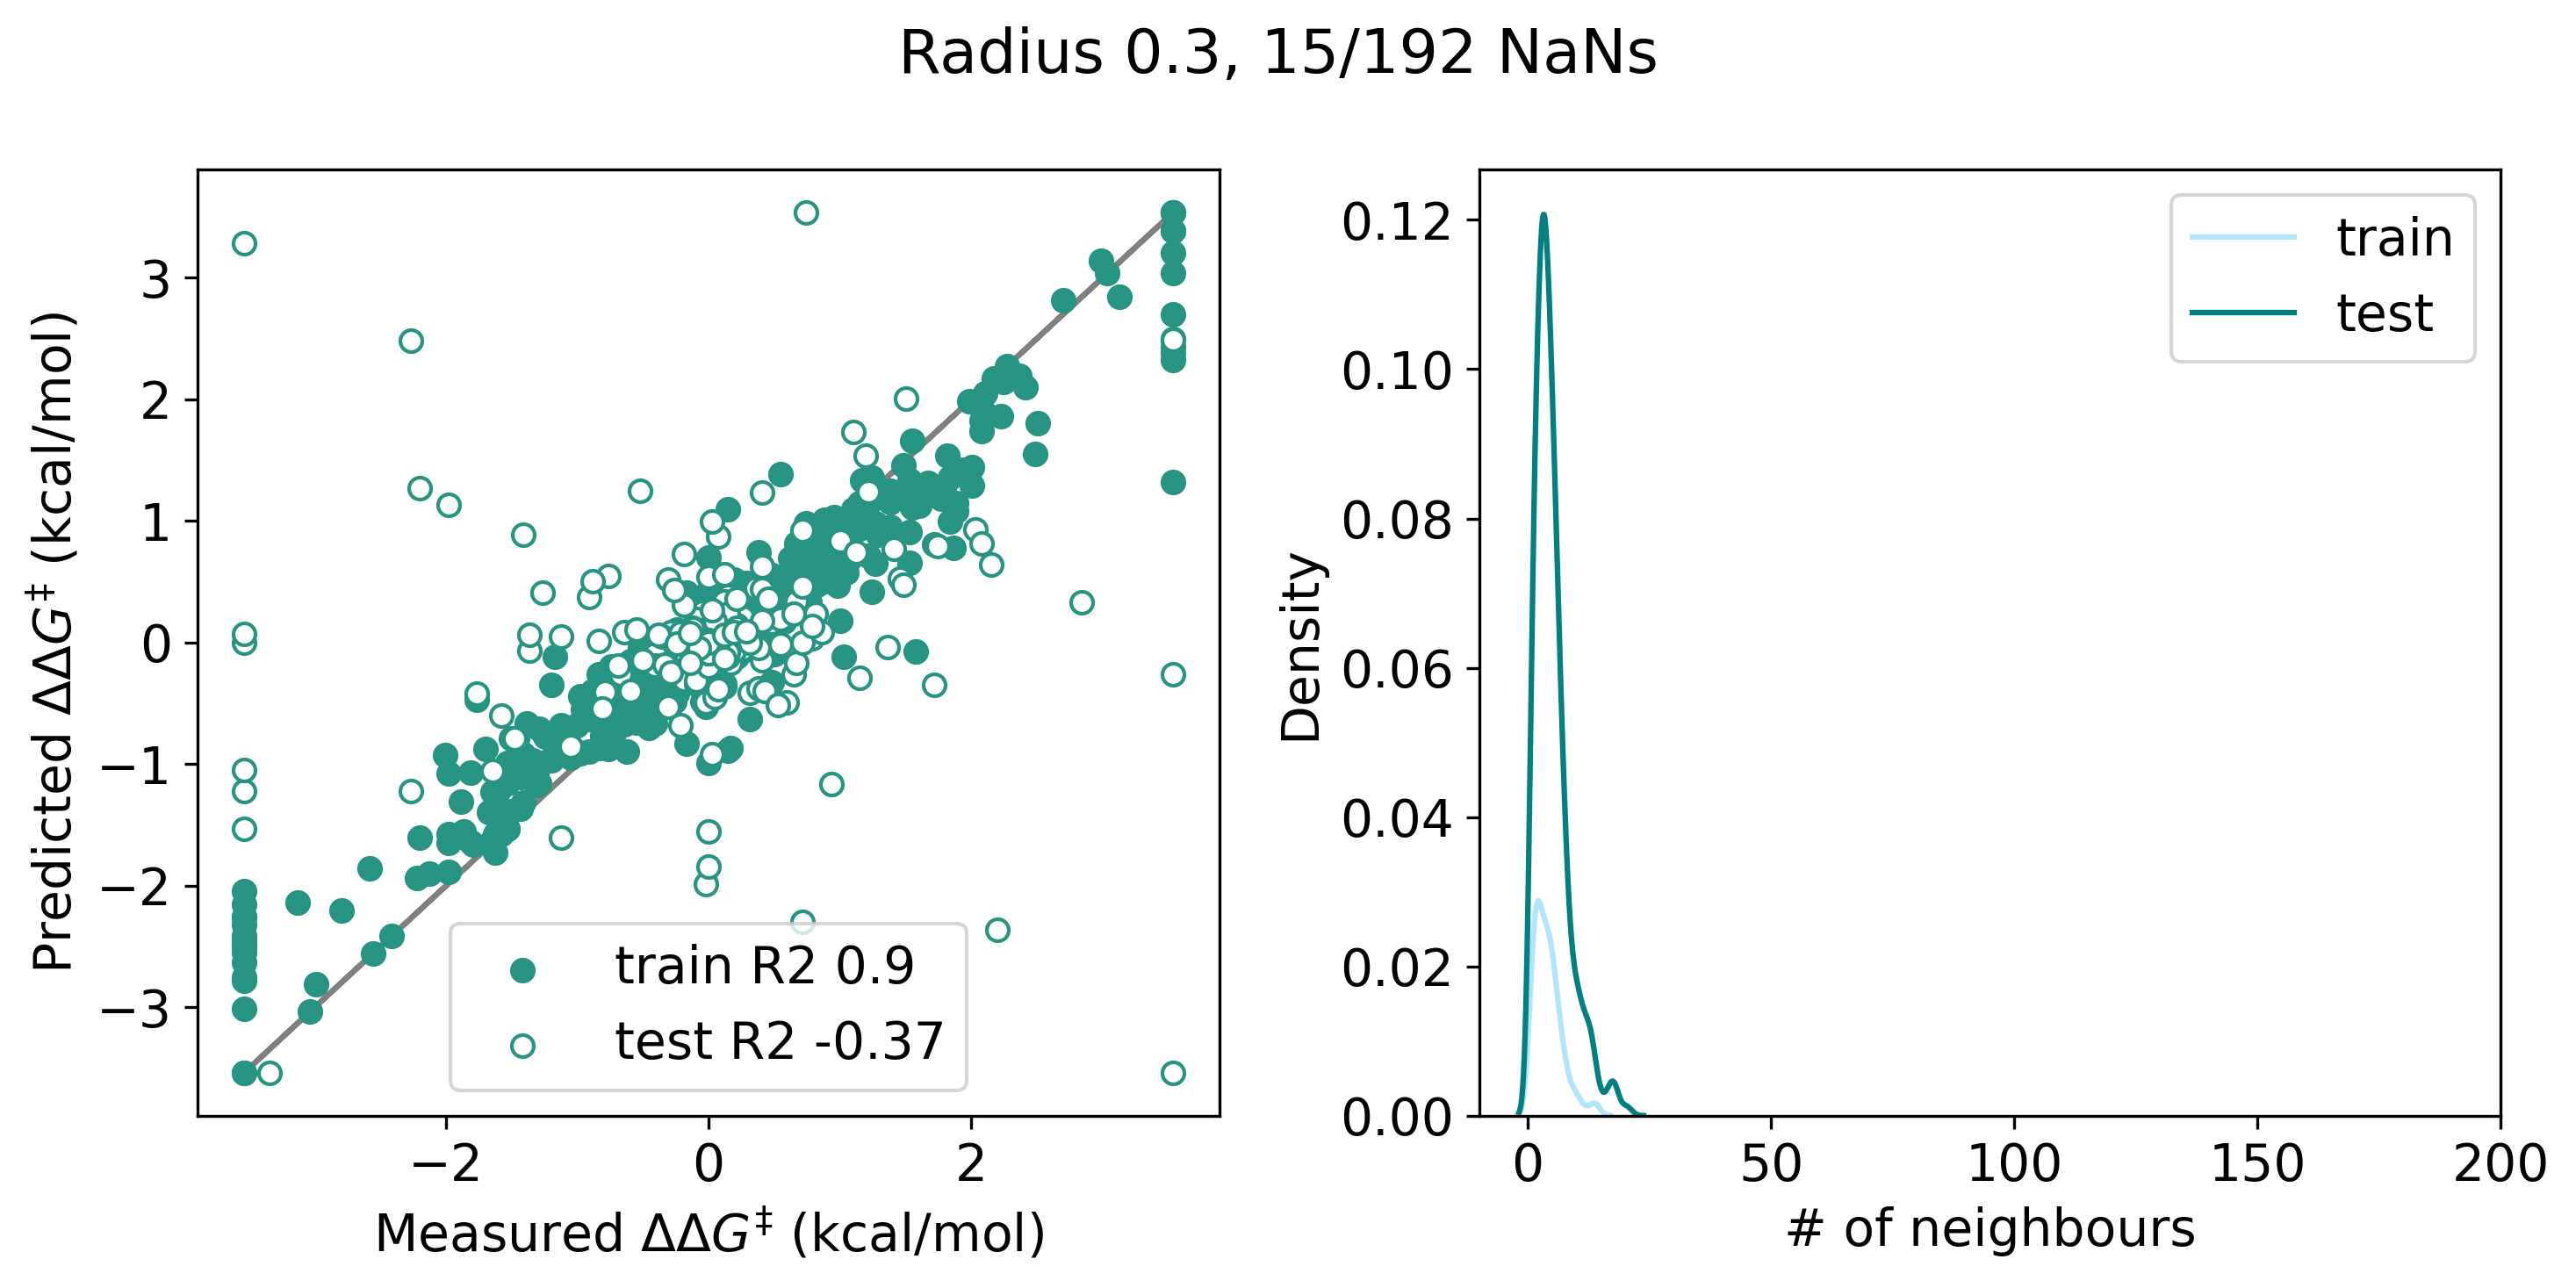

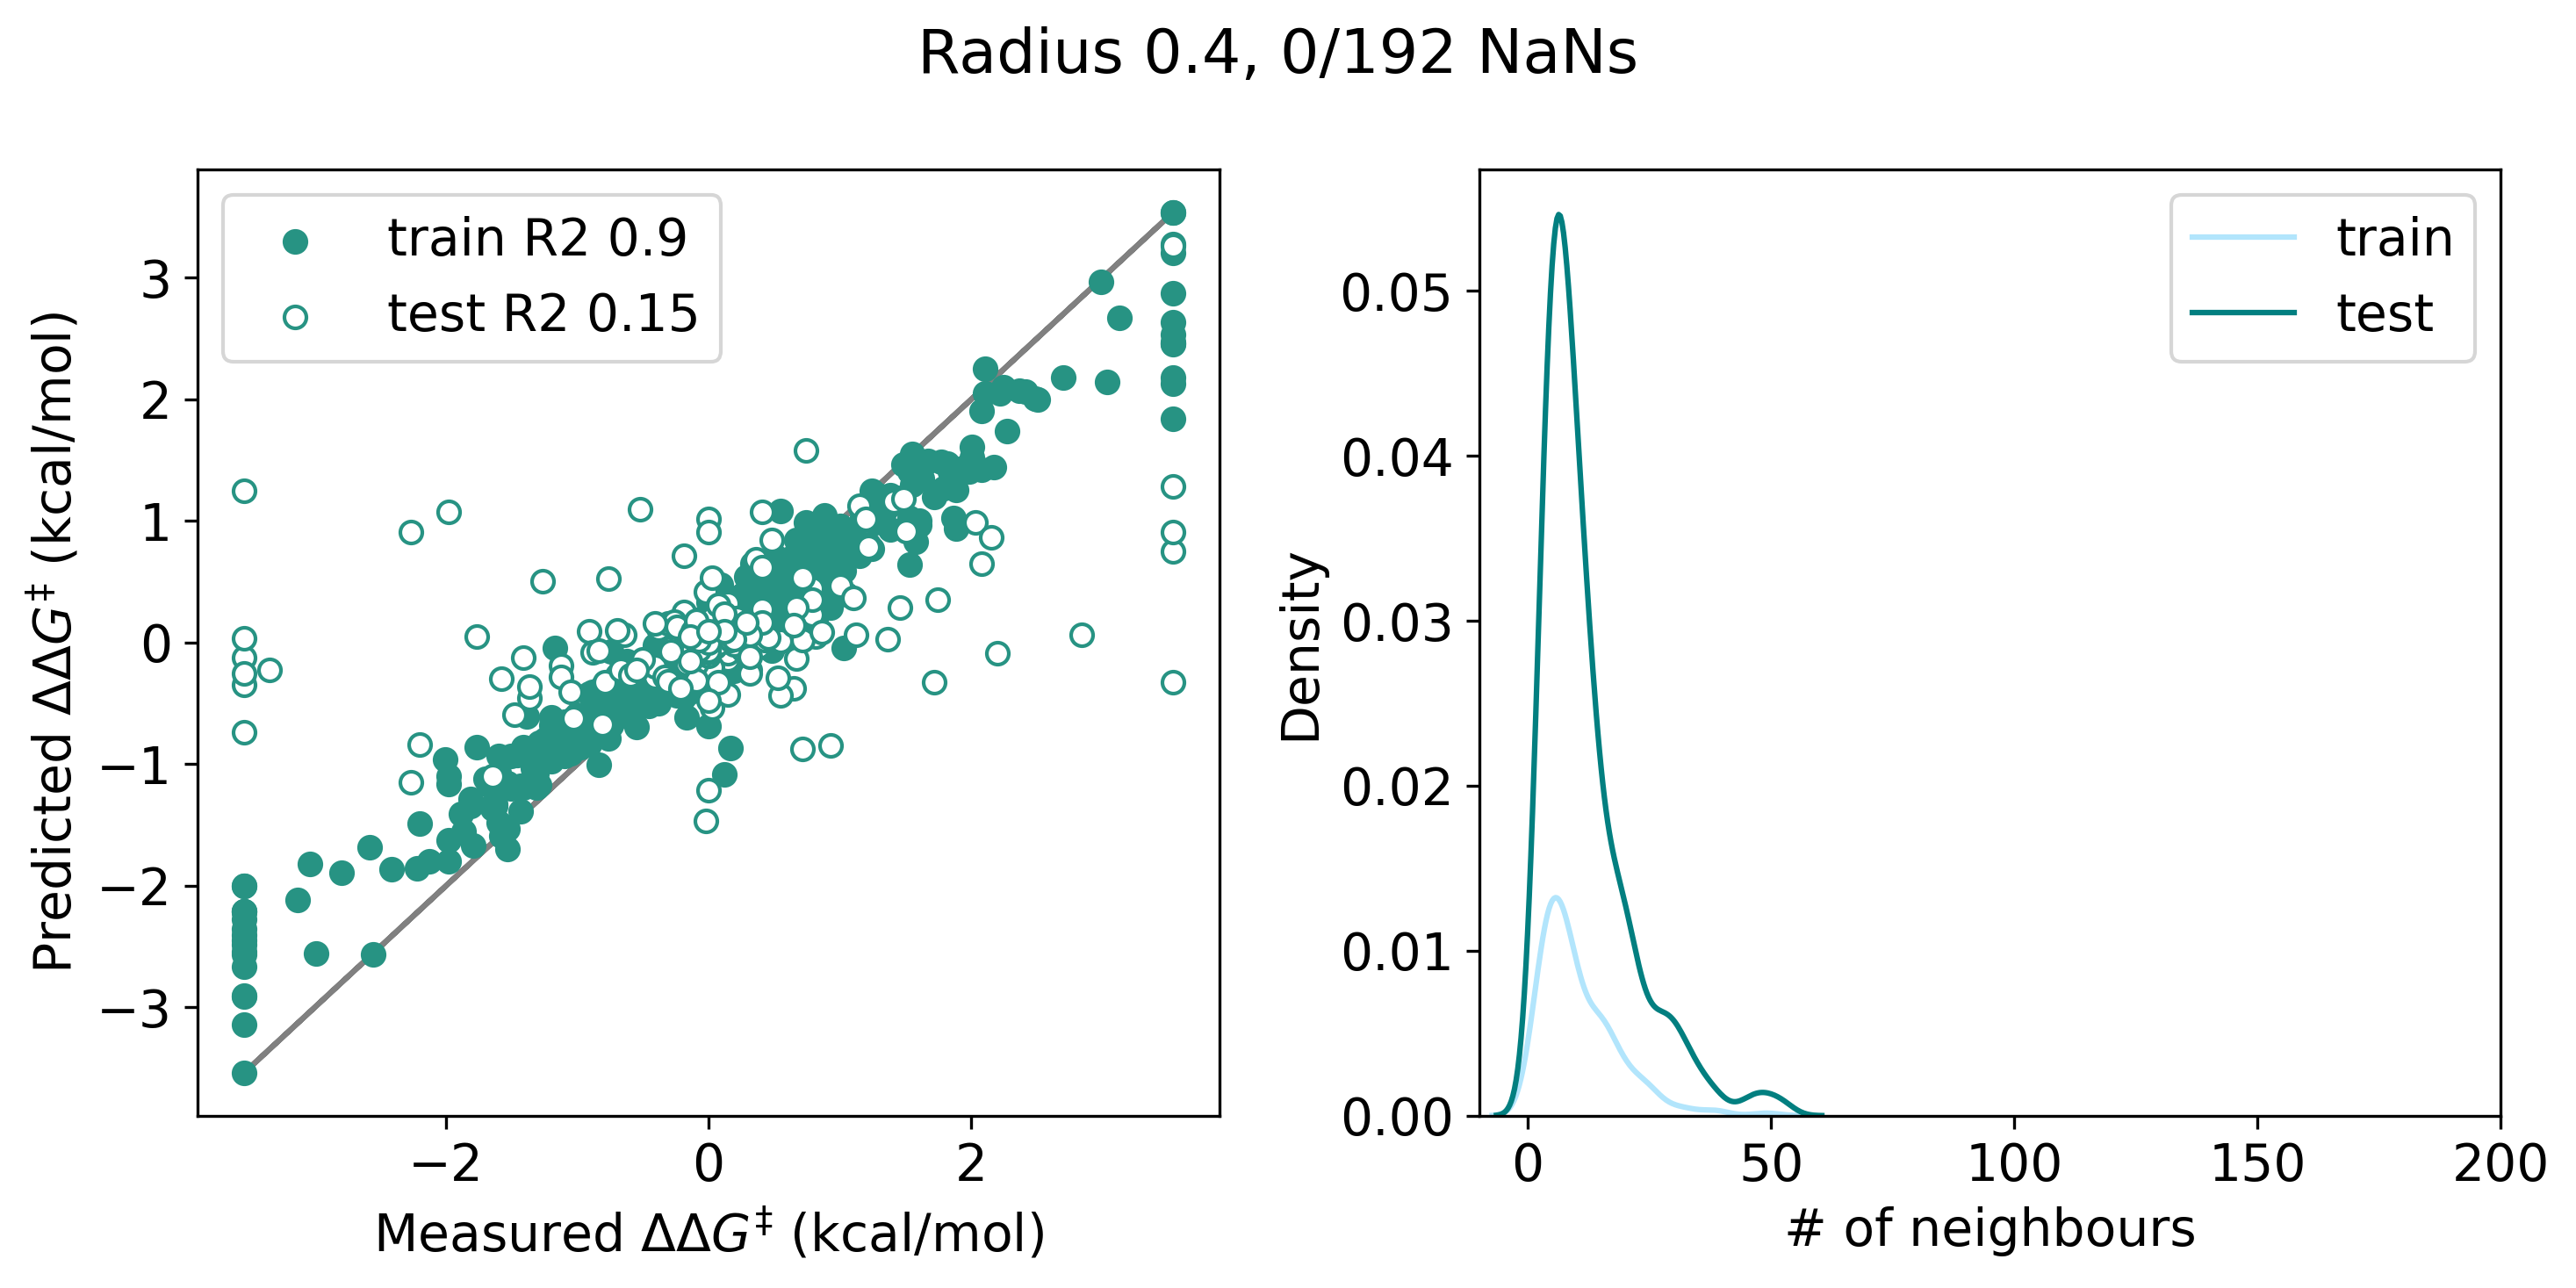

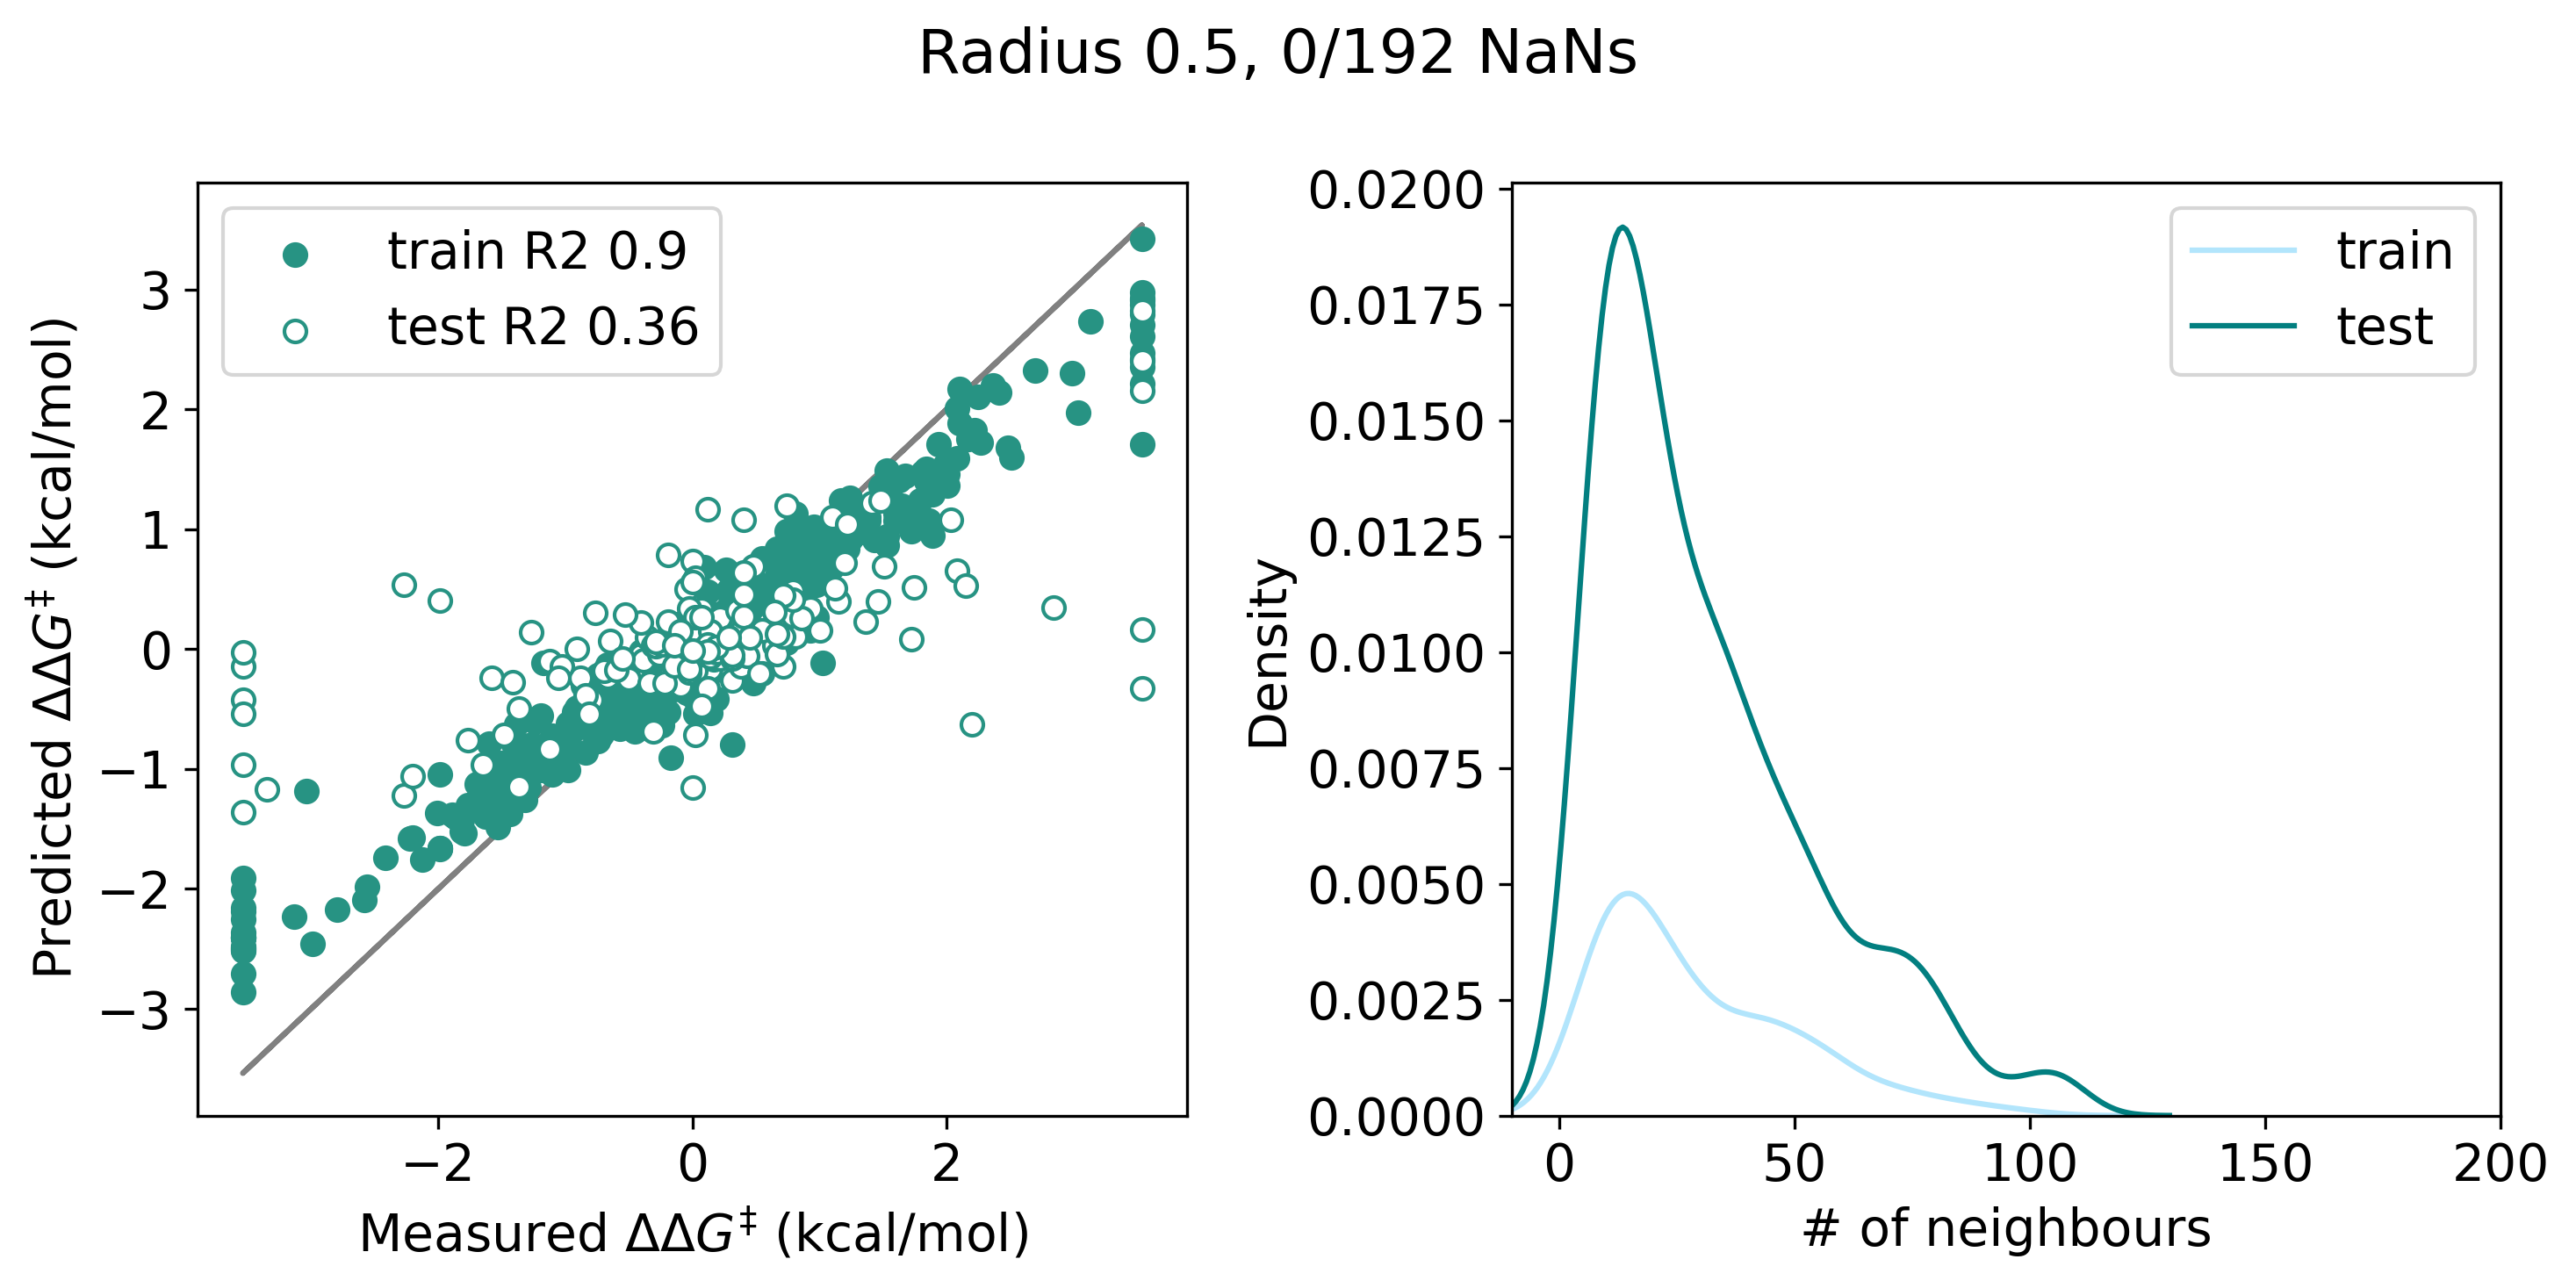

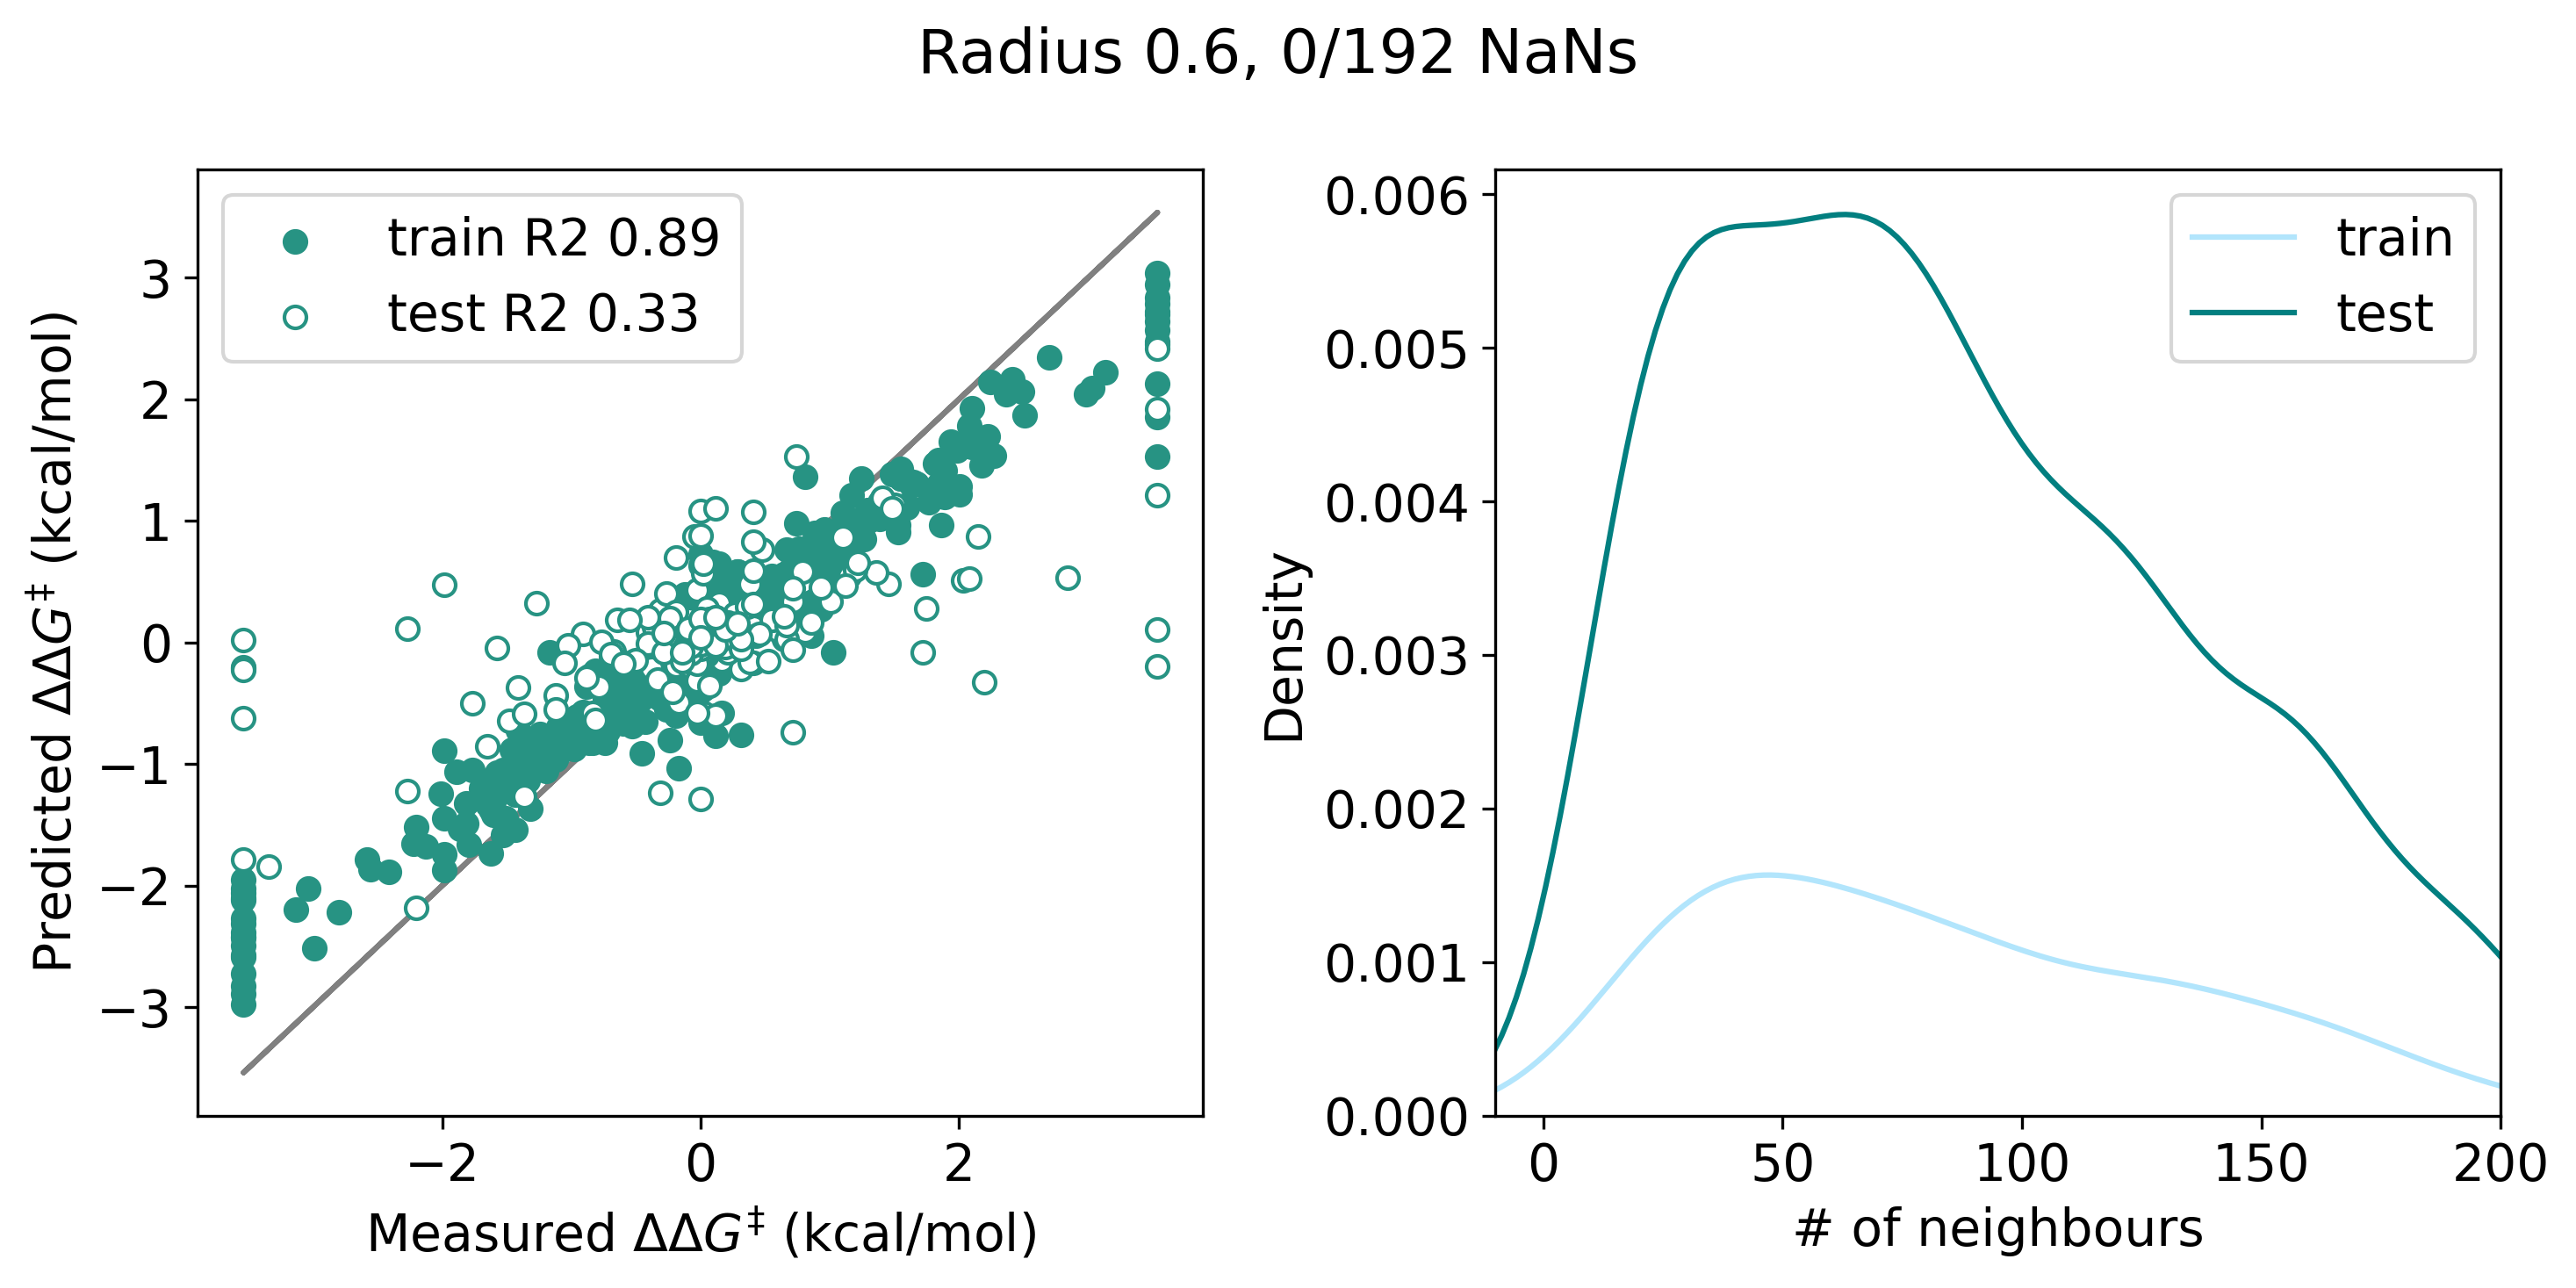

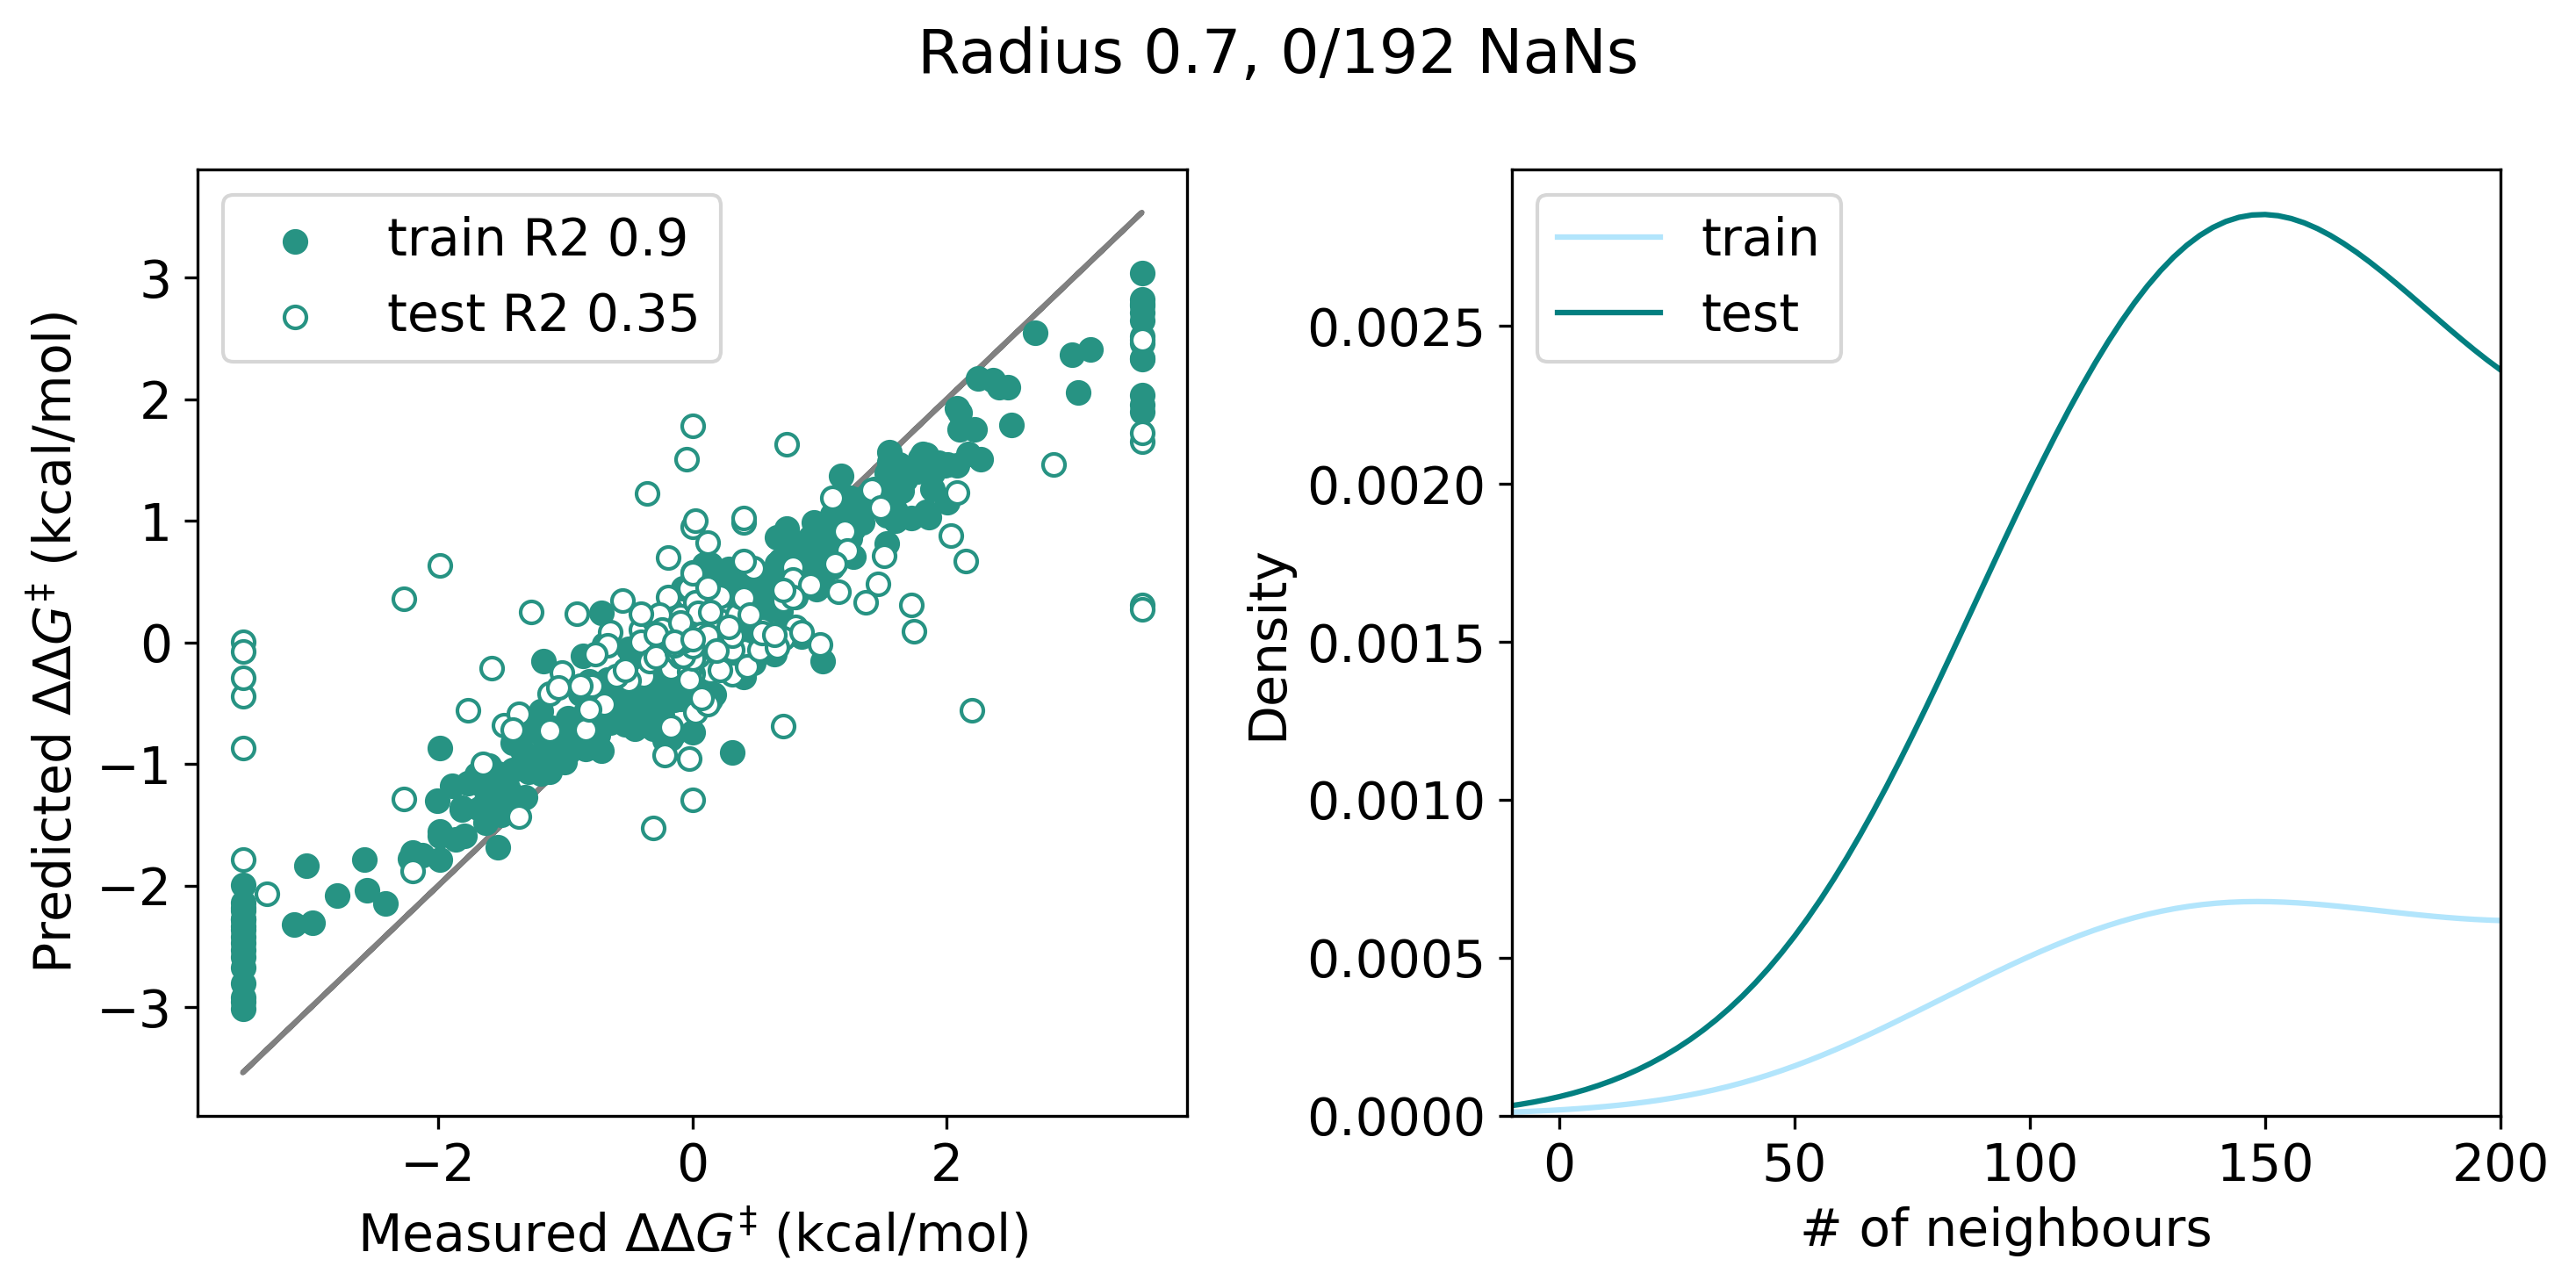

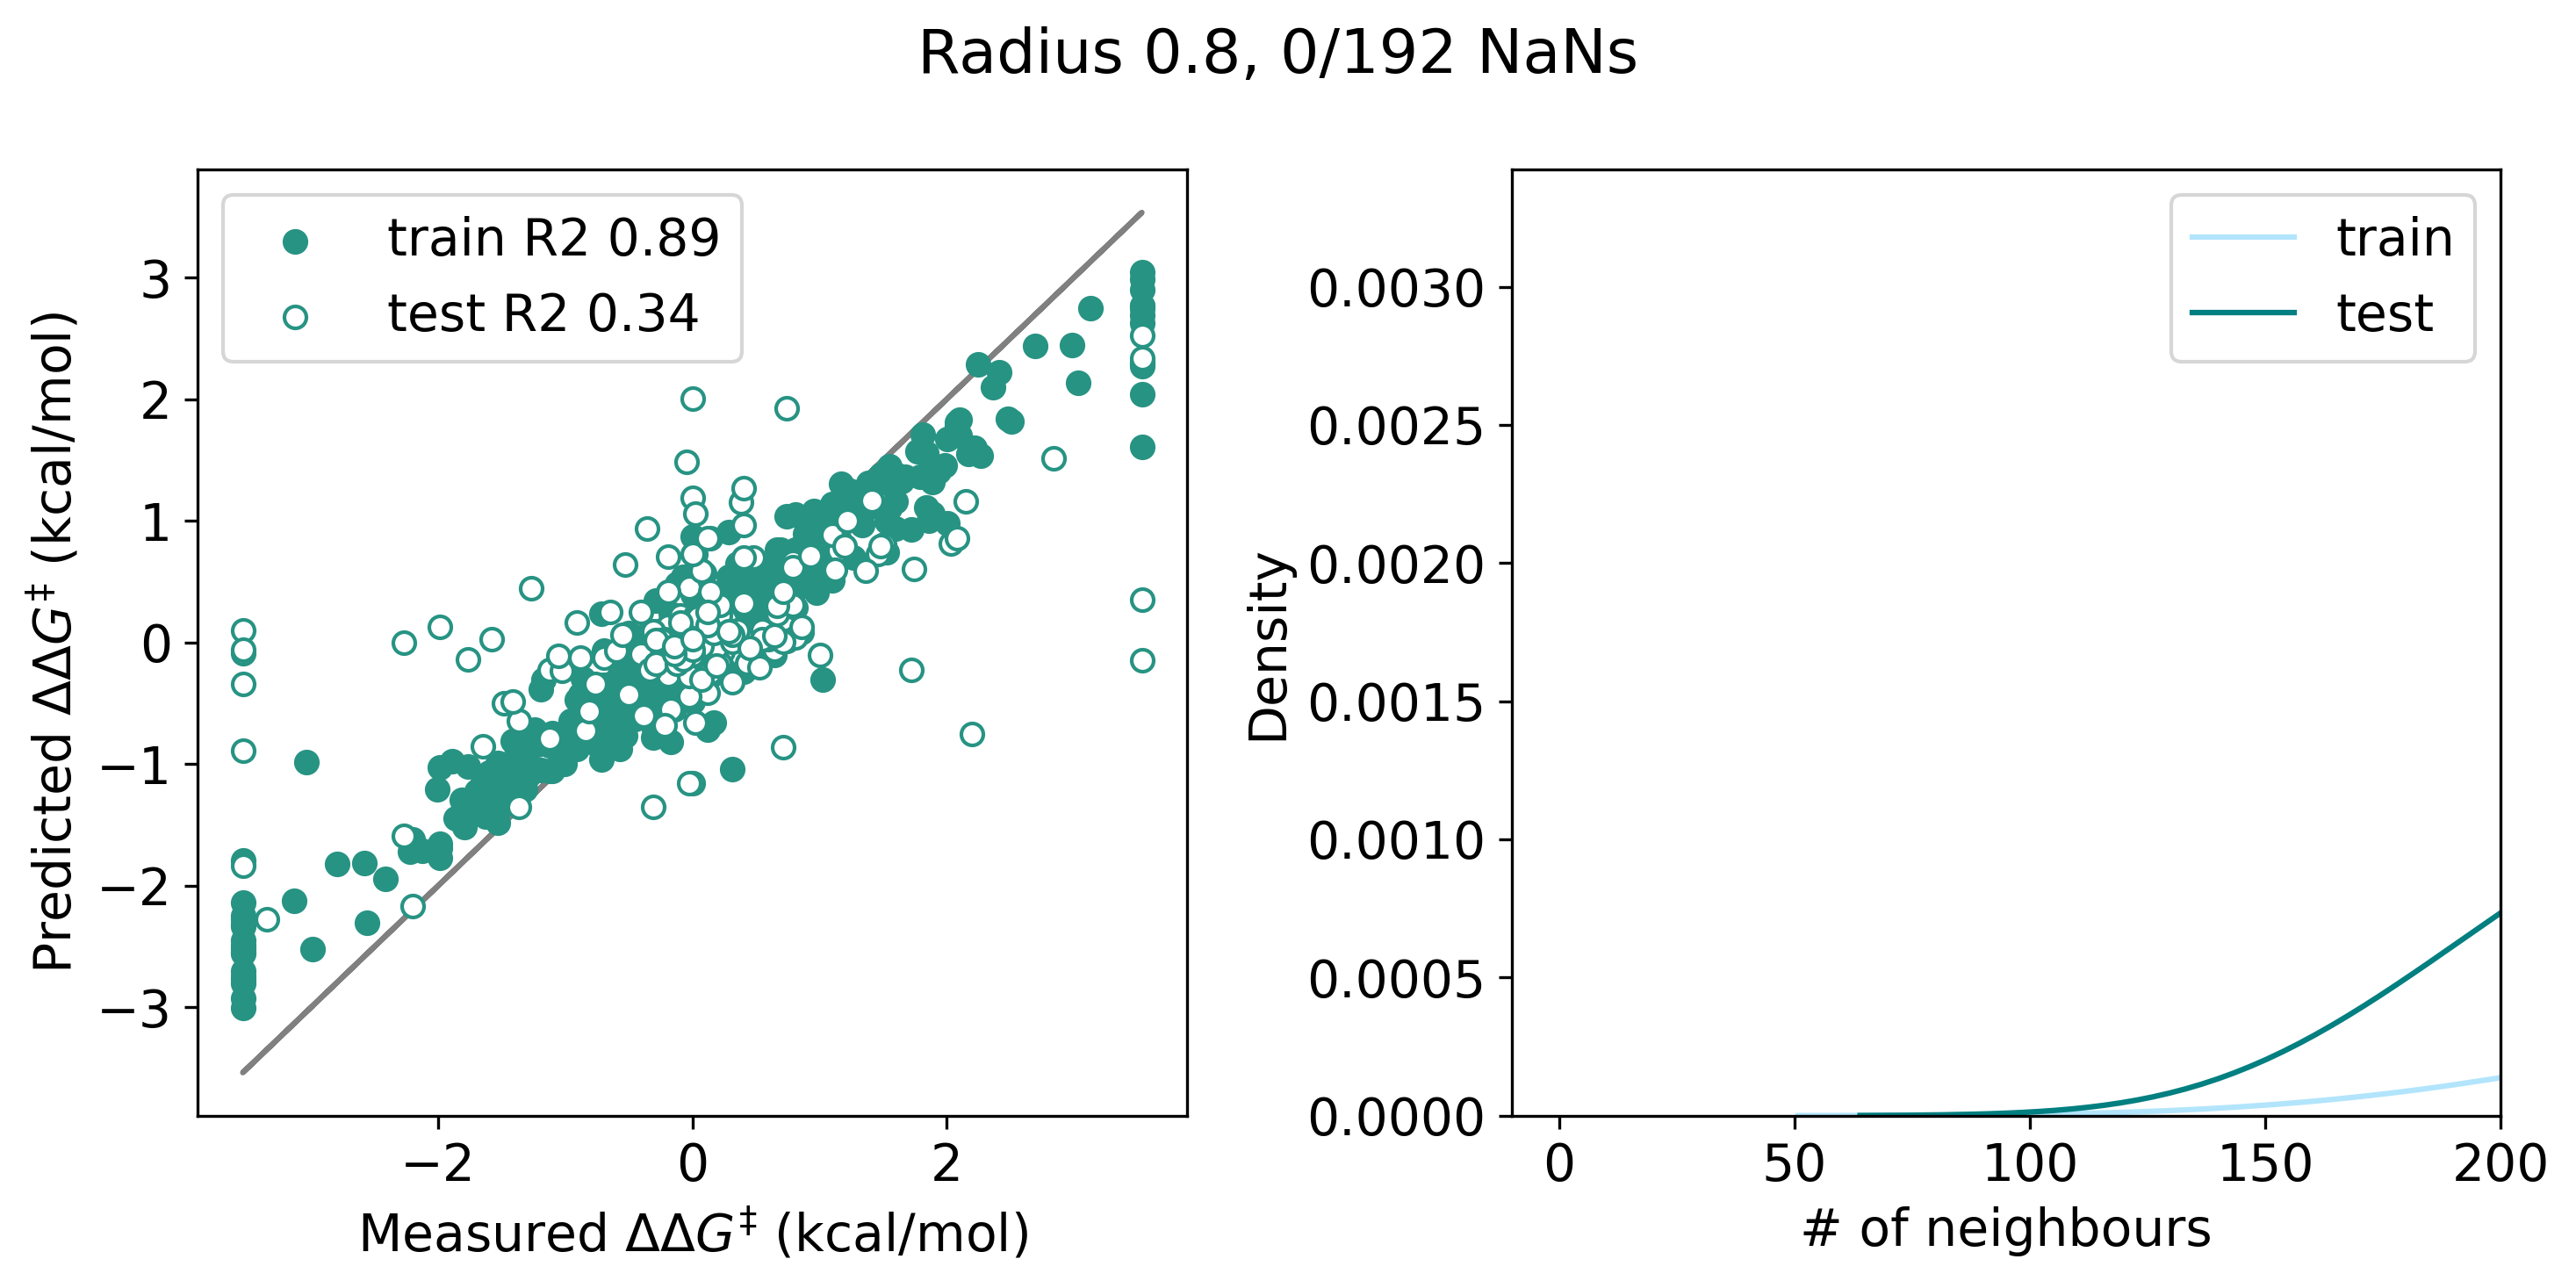

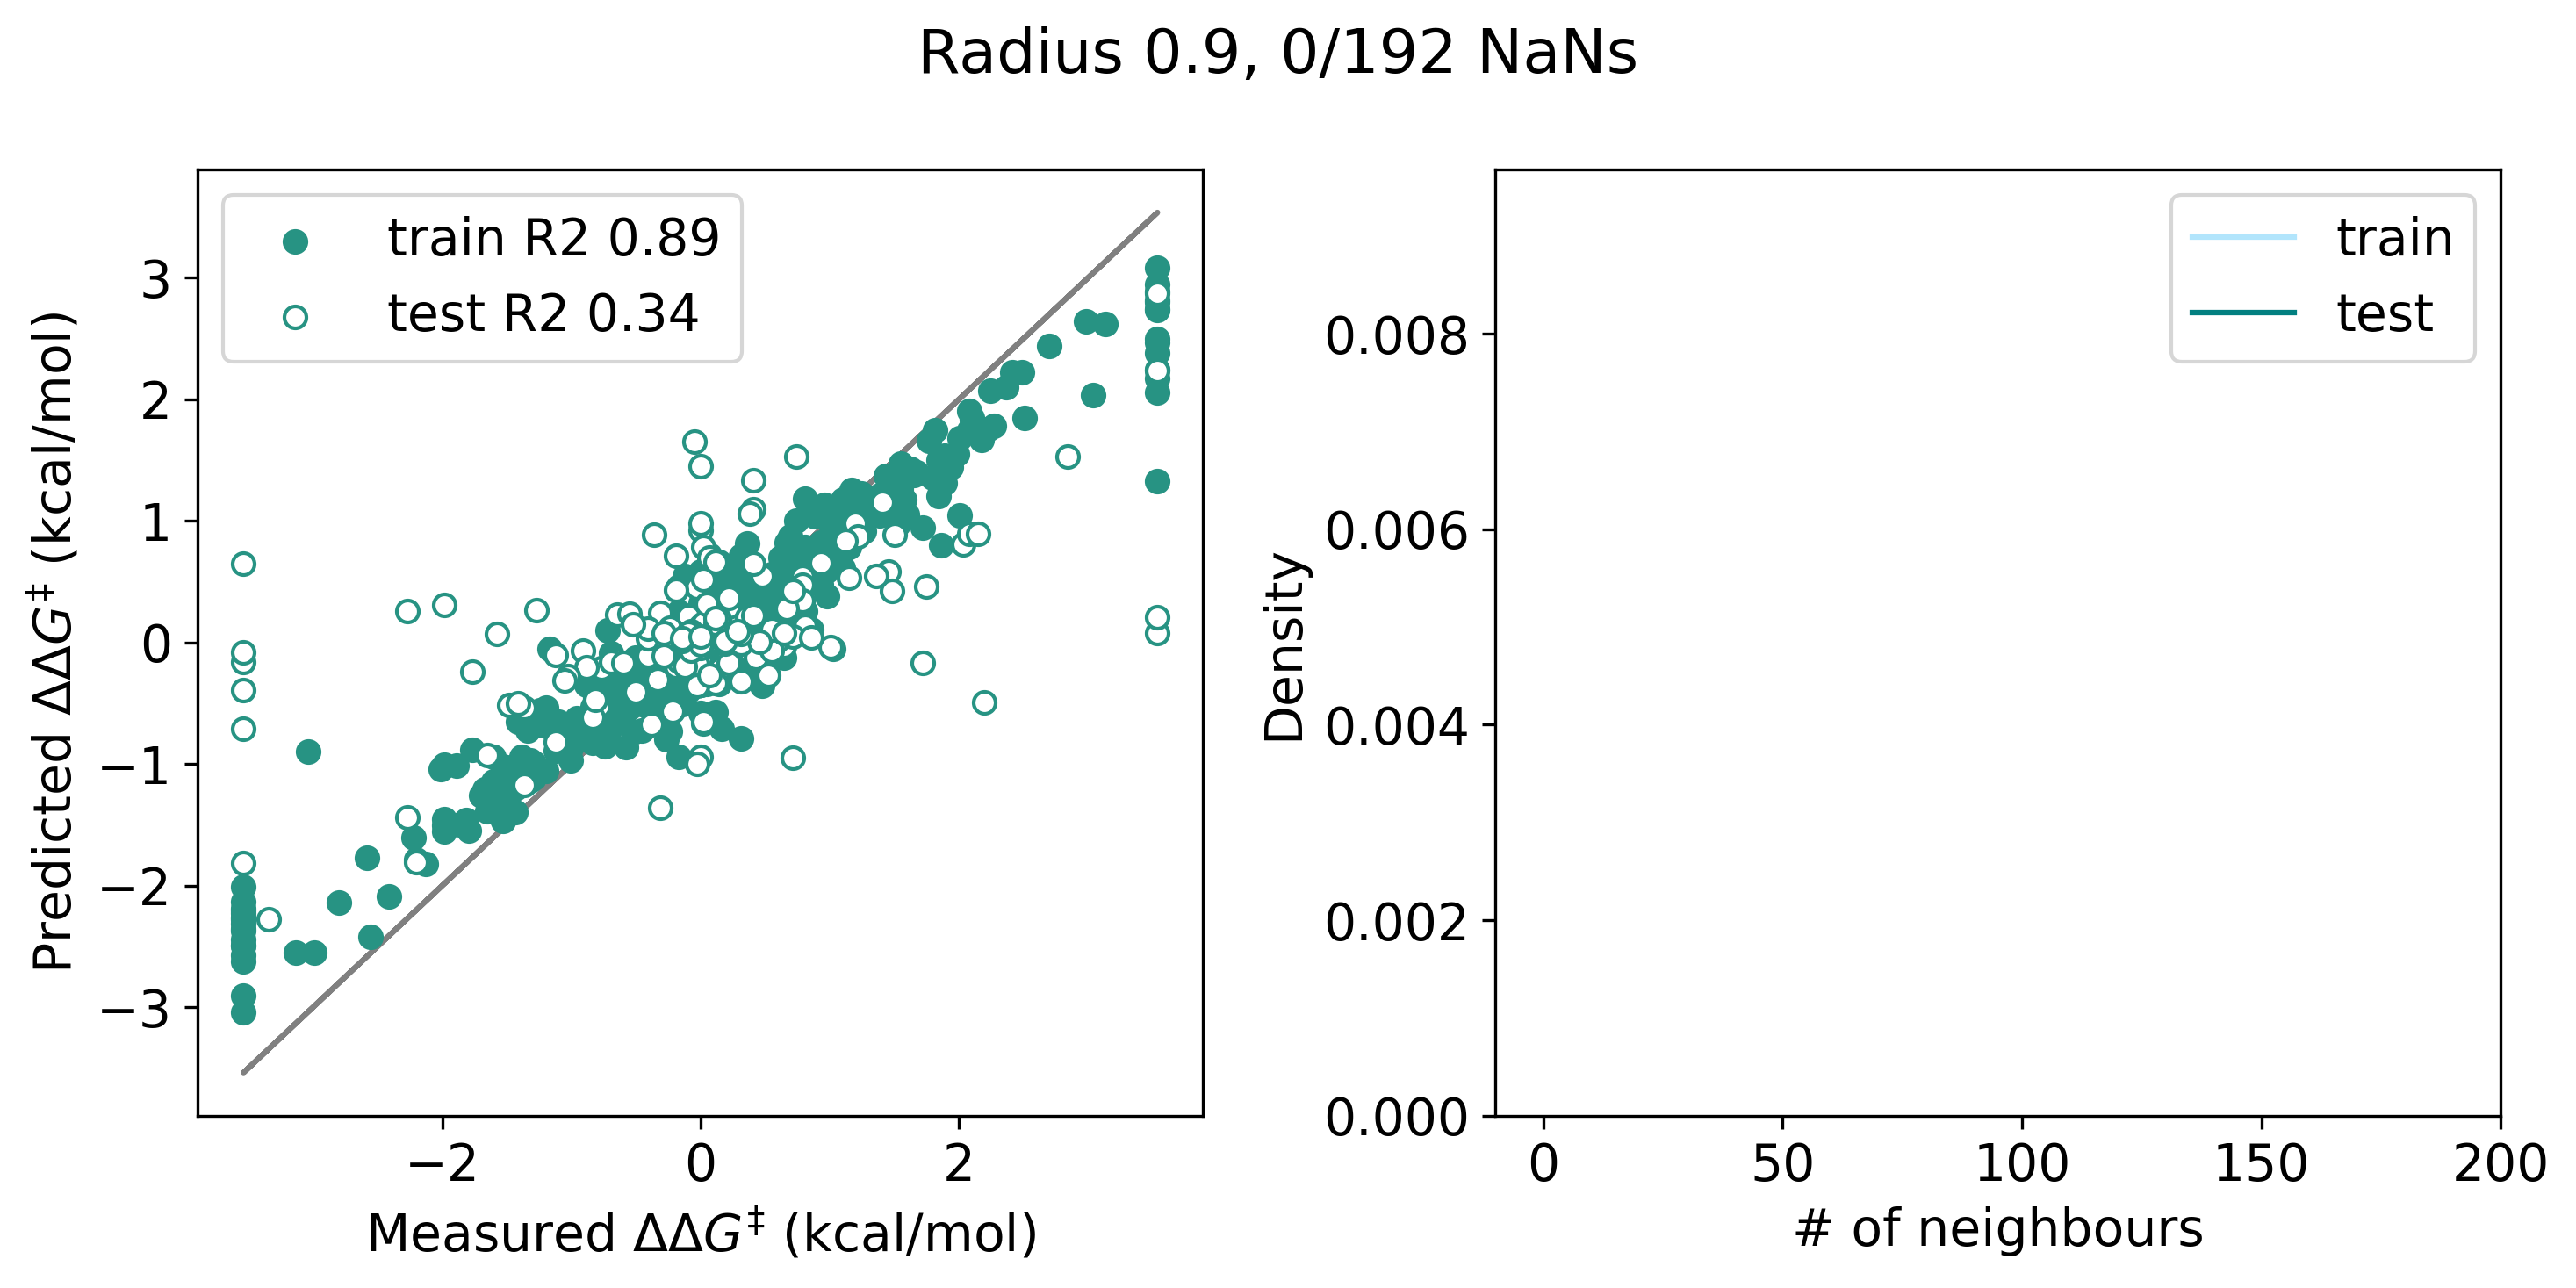

'\nprint(RaRF_mae)\nprint(nans)\nprint(avg_neighbours)\nprint(all_reactions)\nprint([len(ar) for ar in all_reactions])\nprint(reaction_list)\nprint(test_r2s)\n'

In [51]:
distances = utils.get_distances(X_train,X_test)


# need X_train, y_train, X_test, y_test, distances
results = []

for radius in np.divide(range(1,10),10):
    results.append(run_and_plot(radius, X_train, y_train, X_test, y_test, distances))

RaRF_mae, nans, avg_neighbours, all_reactions, reaction_list, test_r2s = zip(*results)

"""
print(RaRF_mae)
print(nans)
print(avg_neighbours)
print(all_reactions)
print([len(ar) for ar in all_reactions])
print(reaction_list)
print(test_r2s)
"""

In [52]:
# Wait. Why are those the same? Are they all the same reactions? They must be, right?
# Probably, Double check. Then, save some work.
# They are.
# Then, just do aquisitions.
# But the R2's are a little different. And so are the MAEs. I hope it's not some shenanigs.
# Okay, I need to set an sklearn seed.
# Look at random state. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
RaRF_mae

(0.31070745697896723,
 0.5851238846398981,
 0.7843418160114939,
 0.6572013963578182,
 0.5760651522997663,
 0.603044937227799,
 0.6085844553324834,
 0.6125618261366049,
 0.6094485689531548)

In [53]:
num_reactions = [len(ar) for ar in all_reactions]

In [54]:
# Reactions used starting from the 5th (0.6) radius onward are the same.
[all_reactions[i] == all_reactions[i + 1] for i in range(4, 8)]

[False, True, True, True]

In [55]:
cutoffs = np.divide(range(1, 7), 10)

cutoffs

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [56]:
def run_and_plot(radius, X_train, y_train, X_test, y_test, distances, title_extra = None):
    radius_pred, train_neighbours = RaRFRegressor.RaRFRegressor(radius=radius, metric='jaccard', seed=SEED).train_parallel(X_train,y_train, include_self='True')
    radius_testpred, test_neighbours, test_neighbours_list = RaRFRegressor.RaRFRegressor(radius=radius,metric='jaccard', seed=SEED).predict_parallel(X_train, y_train, X_test, distances)    

    test_neighbours = np.array(test_neighbours)
    nan_indexes = []
    index = -1
    for prediction in radius_testpred:
        index +=1
        if np.isnan(prediction) == True:
            nan_indexes.append(index)
        
    radius_testpred_temp = np.delete(radius_testpred,nan_indexes)
    y_test_temp = np.delete(y_test,nan_indexes)

    print(y_test_temp)        

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)


    ax1.plot(y_train,y_train, color='grey', zorder=0)

    train_r2 = r2_score(y_train,radius_pred)
    test_r2 = r2_score(y_test_temp,radius_testpred_temp)
    ax1.scatter(y_train,radius_pred, label='train R2 ' + str(round(train_r2,2)), color='#279383')
    ax1.scatter(y_test_temp,radius_testpred_temp, label='test R2 ' + str(round(test_r2,2)), color='white', edgecolor='#279383')

    ax1.set_xlabel('Measured $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.set_ylabel('Predicted $\Delta\Delta G^‡$ (kcal/mol)')
    ax1.legend()


    ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])
    ax2.legend(['train', 'test'])
    ax2.set_xlim(-10,200)
    ax2.set_xlabel('# of neighbours')

    fig.suptitle(f'Radius {radius}, {len(nan_indexes)}/{len(radius_testpred)} NaNs {title_extra if title_extra else ""}')
    plt.tight_layout()
    plt.show()

    flattened_list = [item for sublist in test_neighbours_list for item in sublist]

    reaction_set = set(flattened_list)


    return (mean_absolute_error(y_test_temp,radius_testpred_temp)), len(nan_indexes), np.average([test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]), reaction_set, test_neighbours_list, test_r2




def get_sorted_neighbours(cutoff, distances): 
    num_test = distances.shape[0]

    
    mask = distances <= cutoff


    
    # the ith element is a list of all neighbours for the ith test example.
    test_neighbours = [np.where(row)[0].tolist() for row in mask]
    
    # the ith element is a list of all neighbours for the ith train example.
    train_neighbours = [np.where(row)[0].tolist() for row in mask.T]
    
    # a list of training examples we've chosen.
    chosen_train = []
    
    
    # number of neighbours already selected for each test example
    num_selected_neighbours = np.array([0] * num_test)
    
    
    # set of test examples that have no more unselected neighbours
    fully_chosen_tests = set([i for i, neighs in enumerate(test_neighbours) if len(neighs) == 0])

    buffer = False
    while (len(fully_chosen_tests) < num_test):

        live_tests = np.array([i for i in range(num_test) if i not in fully_chosen_tests])
    
        # of the test examples that still have unselected neighbours, what is the fewest number of selected neighbours
        fewest_neighs = np.min(num_selected_neighbours[live_tests])
    
        # test examples that have the fewest selected neighbours that still have neighbours to select
        neediest_tests = np.array([t for t in np.where(num_selected_neighbours == fewest_neighs)[0] if t in live_tests])
        cur_mask = mask[neediest_tests]
        
        train_neighbours = [(i, np.where(row)[0].tolist()) for i, row in enumerate(cur_mask.T)]
        train_neighbours = sorted(train_neighbours, key=lambda example: len(example[1]), reverse=True)

        
        # the train example we are adding
        selected = train_neighbours[0][0]
        
        # test_examples that got a new neighbour
        new_neighbours = np.where(mask[:,selected])[0]
        
        chosen_train.append(selected)
        
        # remove the selected reaction from the list of neighbours that have it.
        for neigh in new_neighbours:
            test_neighbours[neigh].remove(selected)
            num_selected_neighbours[neigh] += 1
        
        fully_chosen_tests = set([i for i, neighs in enumerate(test_neighbours) if len(neighs) == 0])
        
        mask[:,selected] = False

    
    return chosen_train




def run_MT(cutoff, max_budget, ref_mae, ref_r2, X_train, y_train, X_test, y_test):
    results = []
    
    distances = utils.get_distances(X_train,X_test)

    sorted_neigh = get_sorted_neighbours(cutoff, distances)
    
    multipliers = np.divide(range(1, 11), 10)
    
    for multiplier in multipliers:
        budget = int(max_budget * multiplier)
        cur_indicies = sorted_neigh[0:budget]
    
        cur_distances = np.full_like(distances, 2)
    
        cur_distances[:,cur_indicies] = distances[:,cur_indicies]
        if(budget == 0):
            print(f"Using only {multiplier*100}% of availale reactions give no training data")
            # nan to skip when plotting, number of non-reactions is all of them, 0 average neighbours, empty reaction lists, nan again
            placeholder_results = [np.nan, X_train.shape[0], 0, [], [], np.nan]
            results.append(tuple(placeholder_results))
            continue

    
        results.append(run_and_plot(cutoff, X_train, y_train, X_test, y_test, cur_distances,  
                                    title_extra = ", Budget: {}, Percent Used: {:.1f}%".format(budget, multiplier * 100)))


    
    cur_RaRF_mae, cur_nans, cur_avg_neighbours, cur_all_reactions, cur_reaction_list, cur_test_r2s = zip(*results)

    print([len(ar) for ar in cur_all_reactions])
    print([int(max_budget * m) for m in multipliers])
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), dpi=300)

    title = "MAE to Percent of Reactions Used \n(Radius = {})".format(cutoff)

    # random large number to give the illusion of a line.
    ref_num_points = 1000

    ref_x = np.array(range(0, ref_num_points)) * 100 / ref_num_points

    x_label = "% of Reactions Used\nvs. Single Target"

    ax1.set_title(title)
    ax1.set_ylabel("MAE")
    ax1.set_xlabel(x_label)
    ax1.scatter(ref_x, [ref_mae] * ref_num_points, label = "Reference", s=0.5)
    ax1.scatter(100 * multipliers, cur_RaRF_mae, label="Actual")
    ax1.legend()

    ax2.set_title("R^2 to Percent of Reactions Used \n(Radius = 0.1)")
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    ax2.set_ylabel("R^2",rotation=270)
    ax2.set_xlabel(x_label)
    ax2.scatter(ref_x, [ref_r2] * ref_num_points, label = "Reference", s=0.5)
    ax2.scatter(100 * multipliers, cur_test_r2s, label="Actual")

    ax2.legend()

    print("RARF MAE: {}".format(cur_RaRF_mae))
    print("RARF R2: {}".format(cur_test_r2s))

    plt.show()

Using only 10.0% of availale reactions give no training data
[0.14340344]


/home/roy/anaconda3/envs/neighbour/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


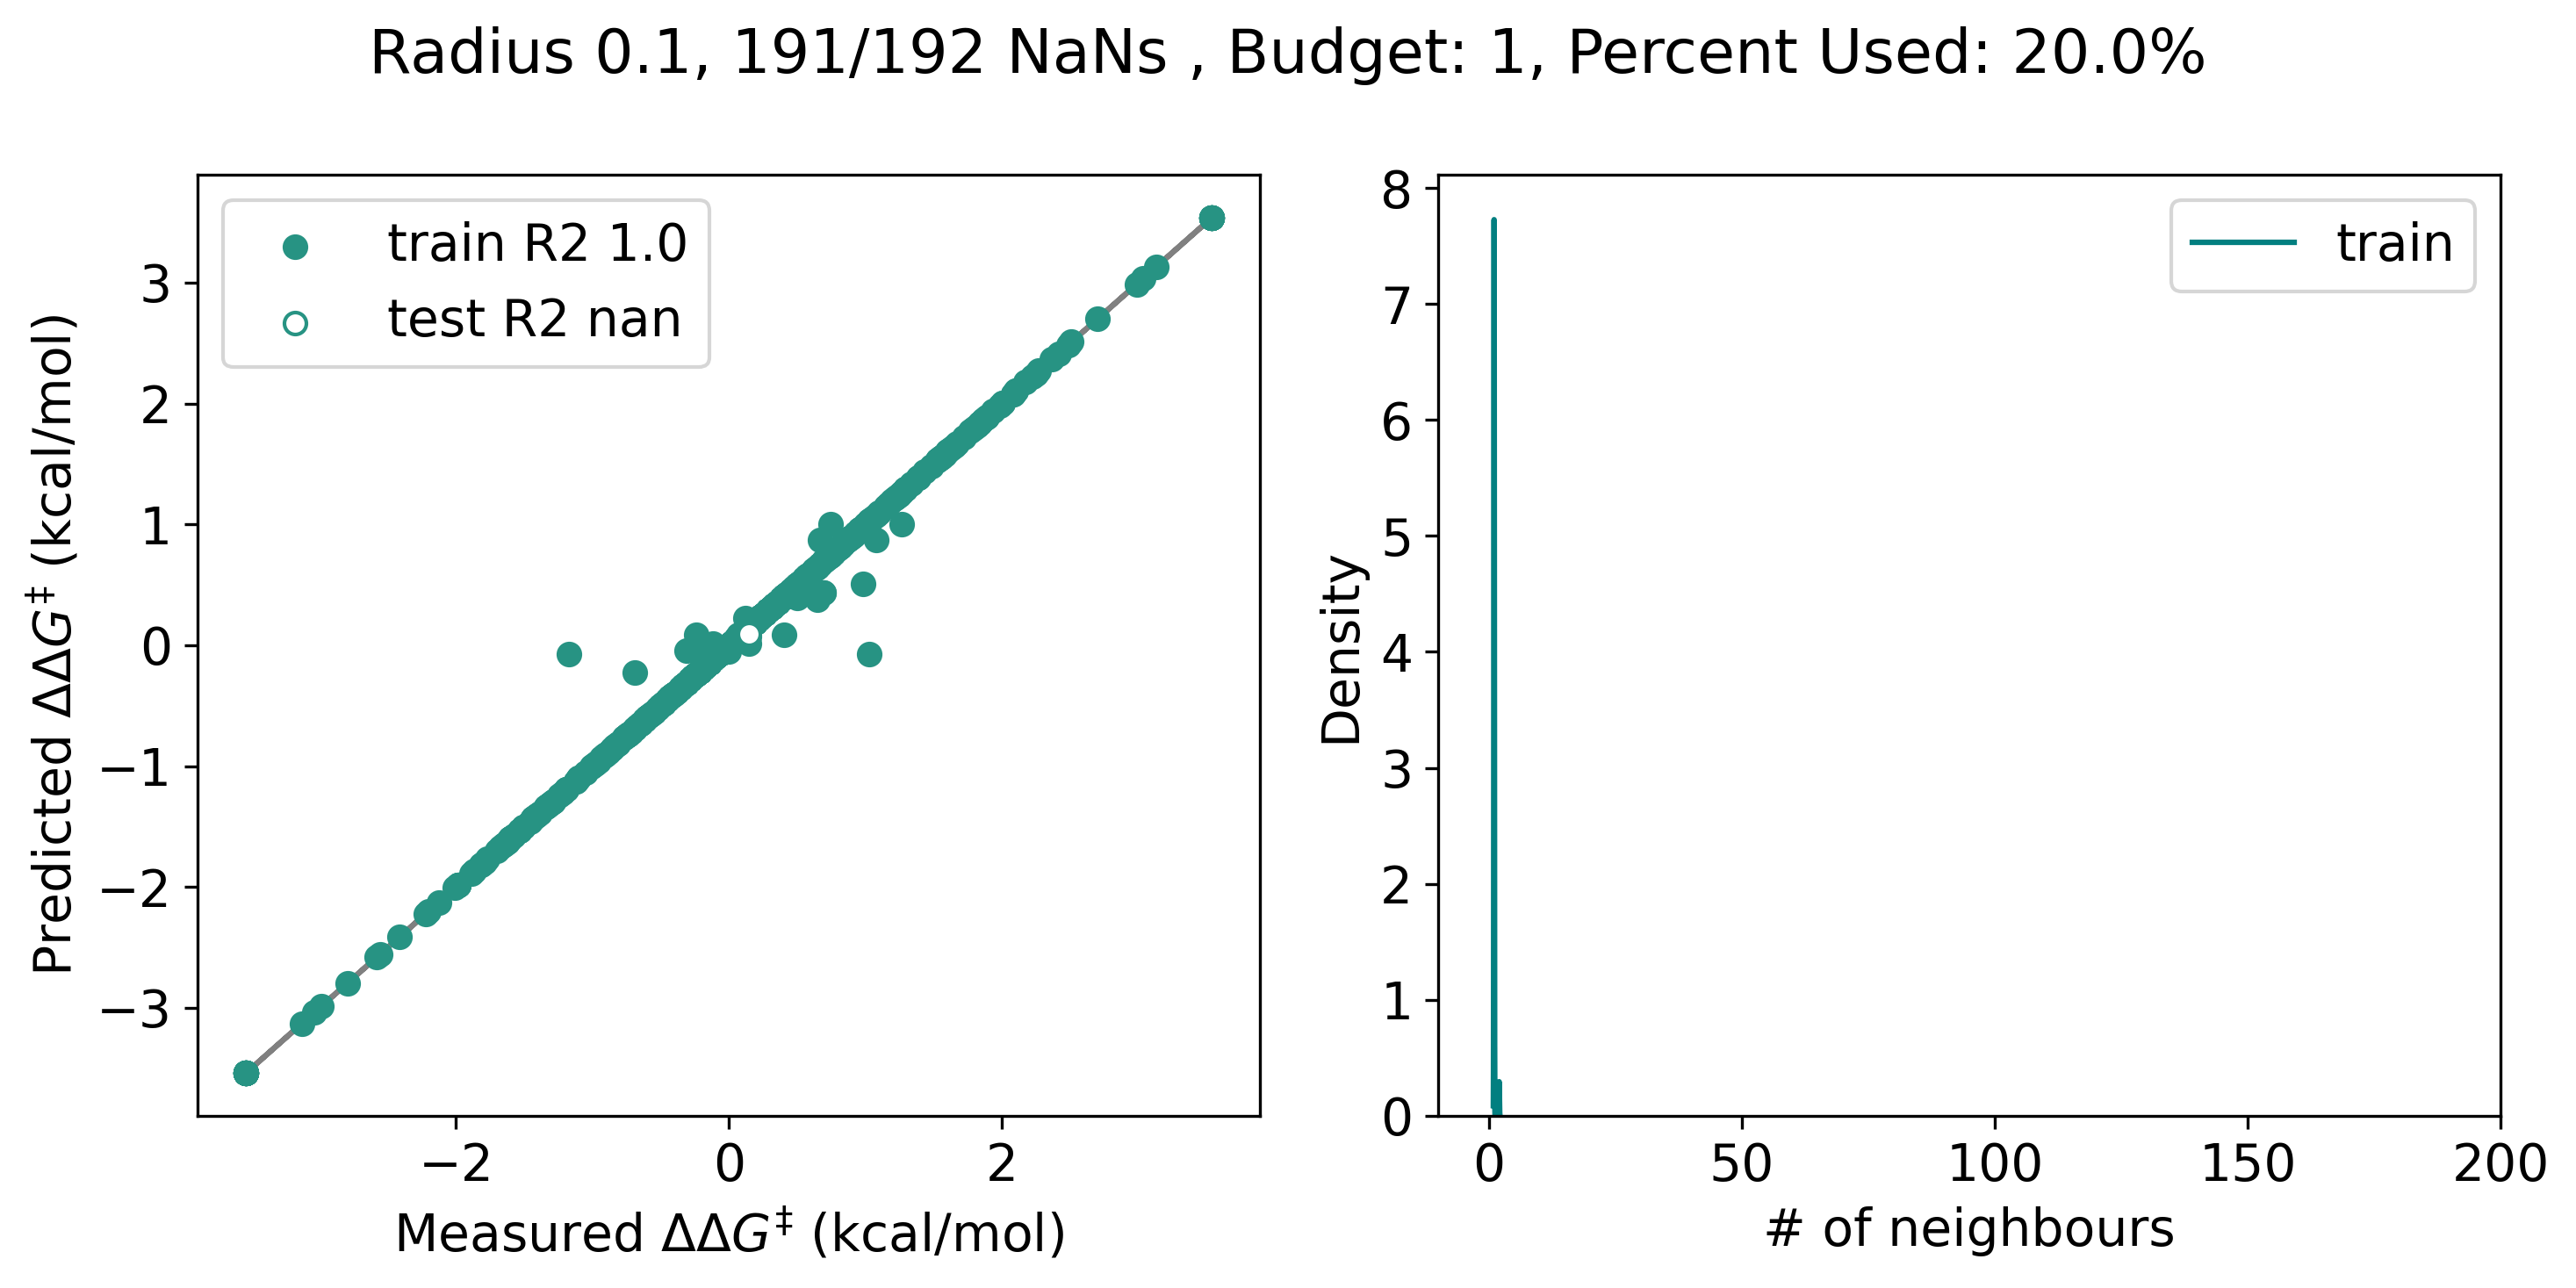

[0.14340344]


/home/roy/anaconda3/envs/neighbour/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


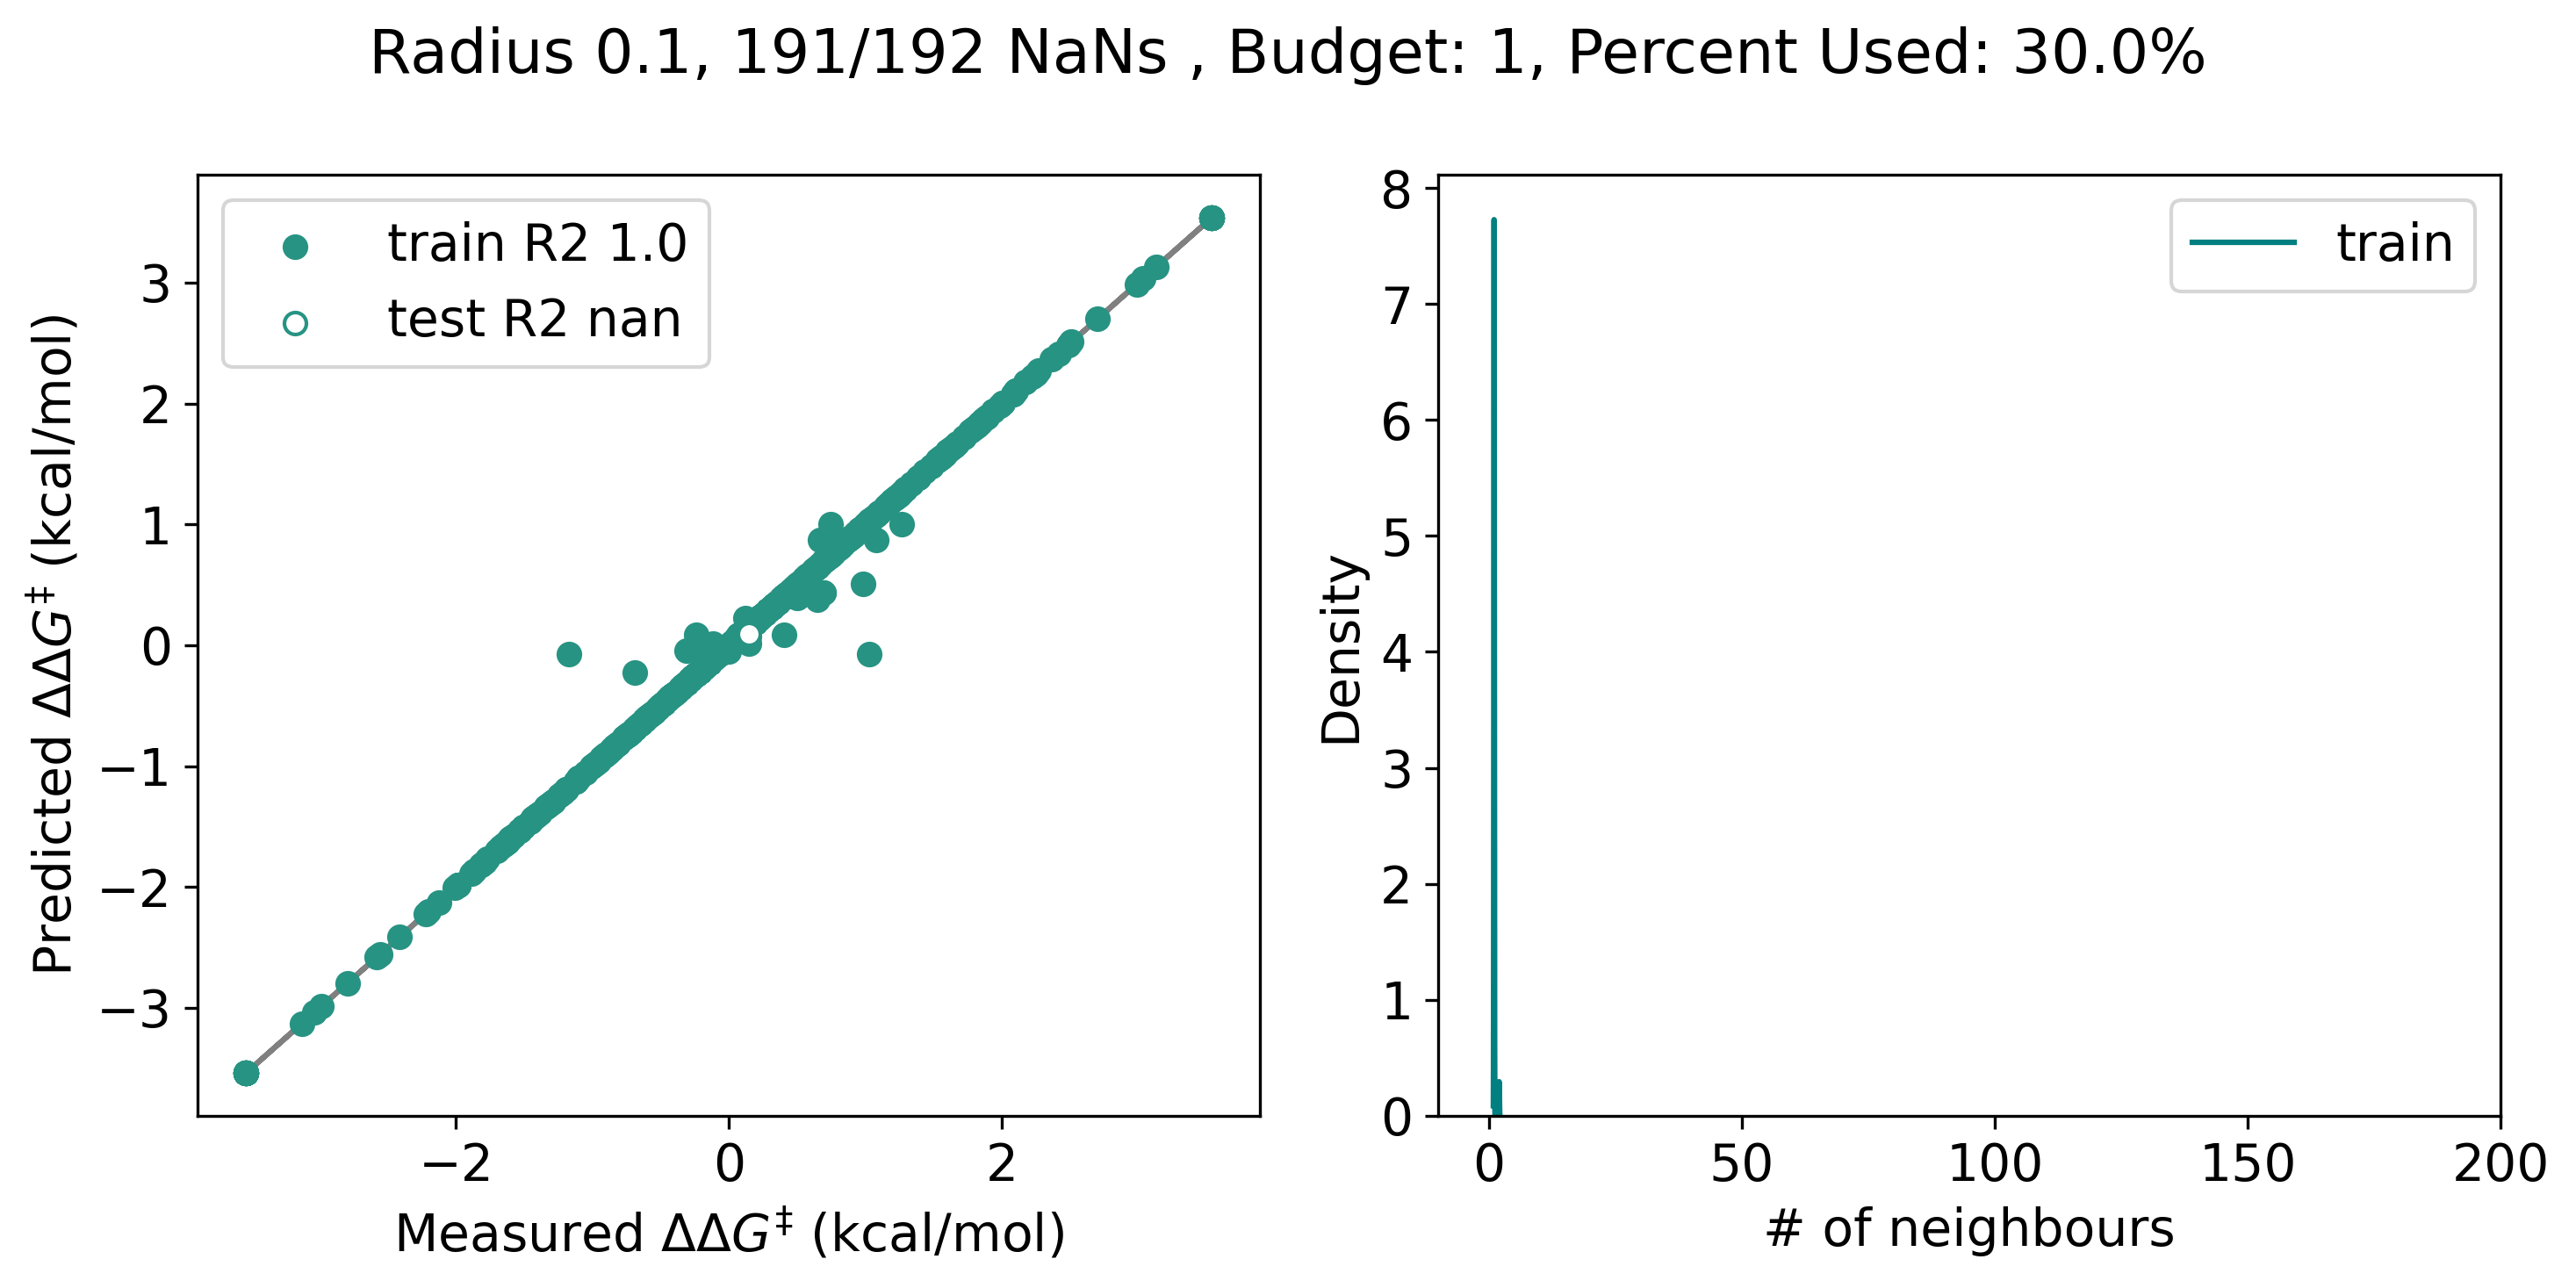

[ 0.14340344 -0.23900574]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


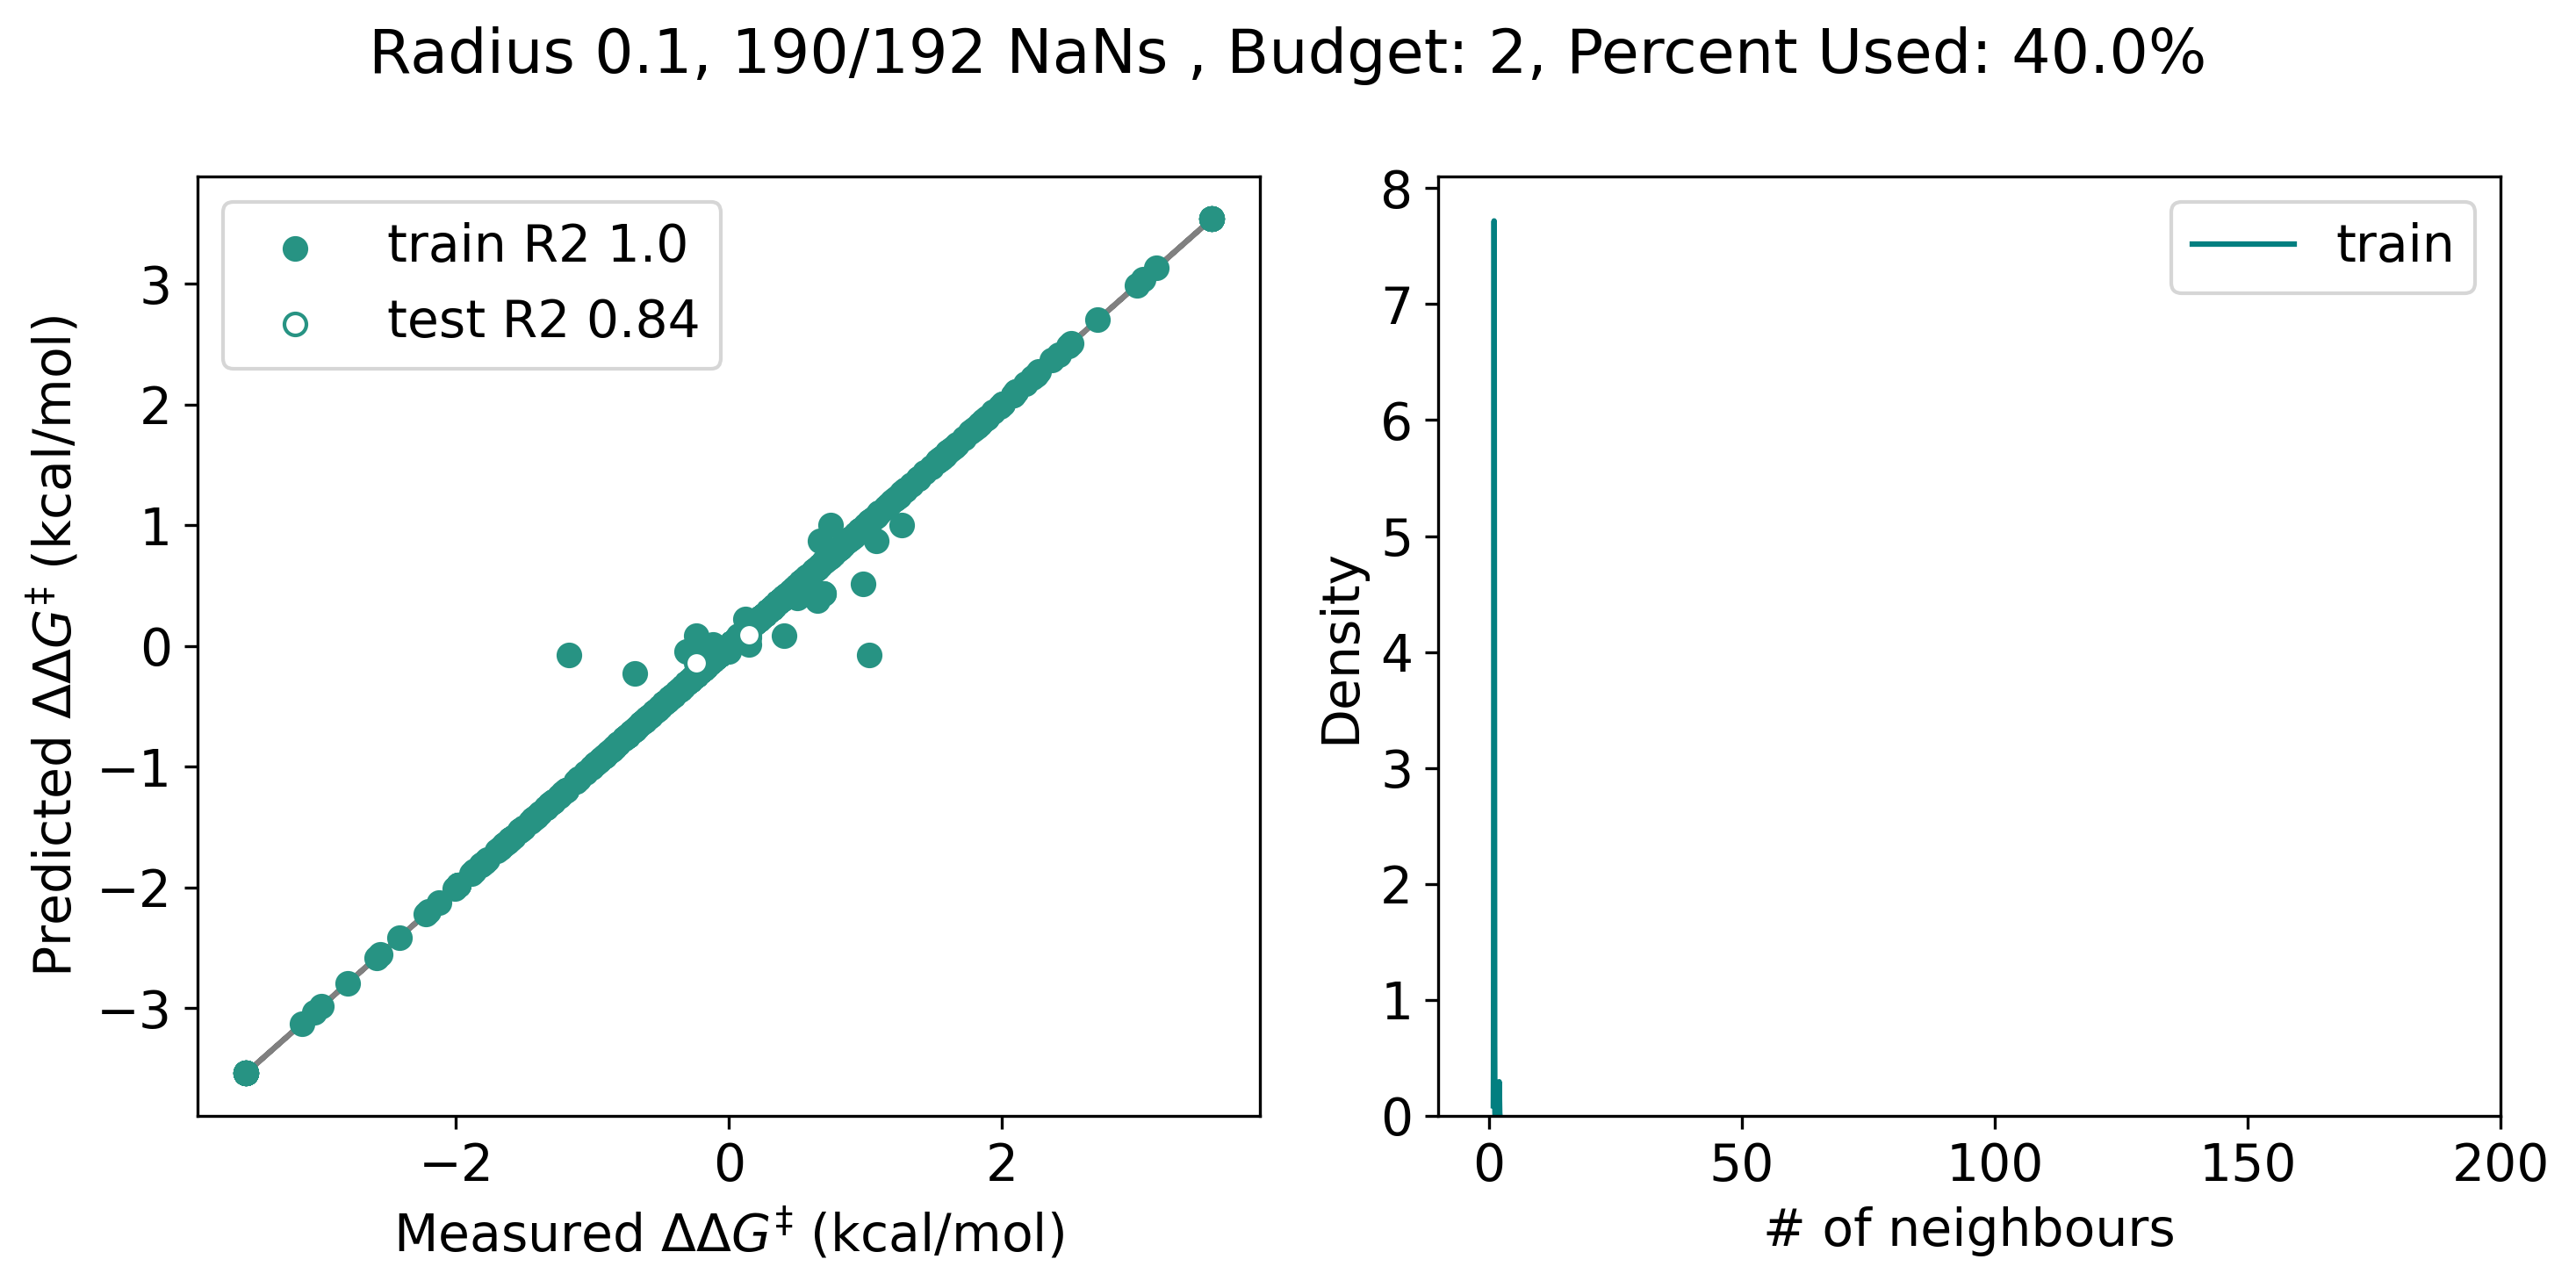

[-0.09560229  0.14340344 -0.23900574]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


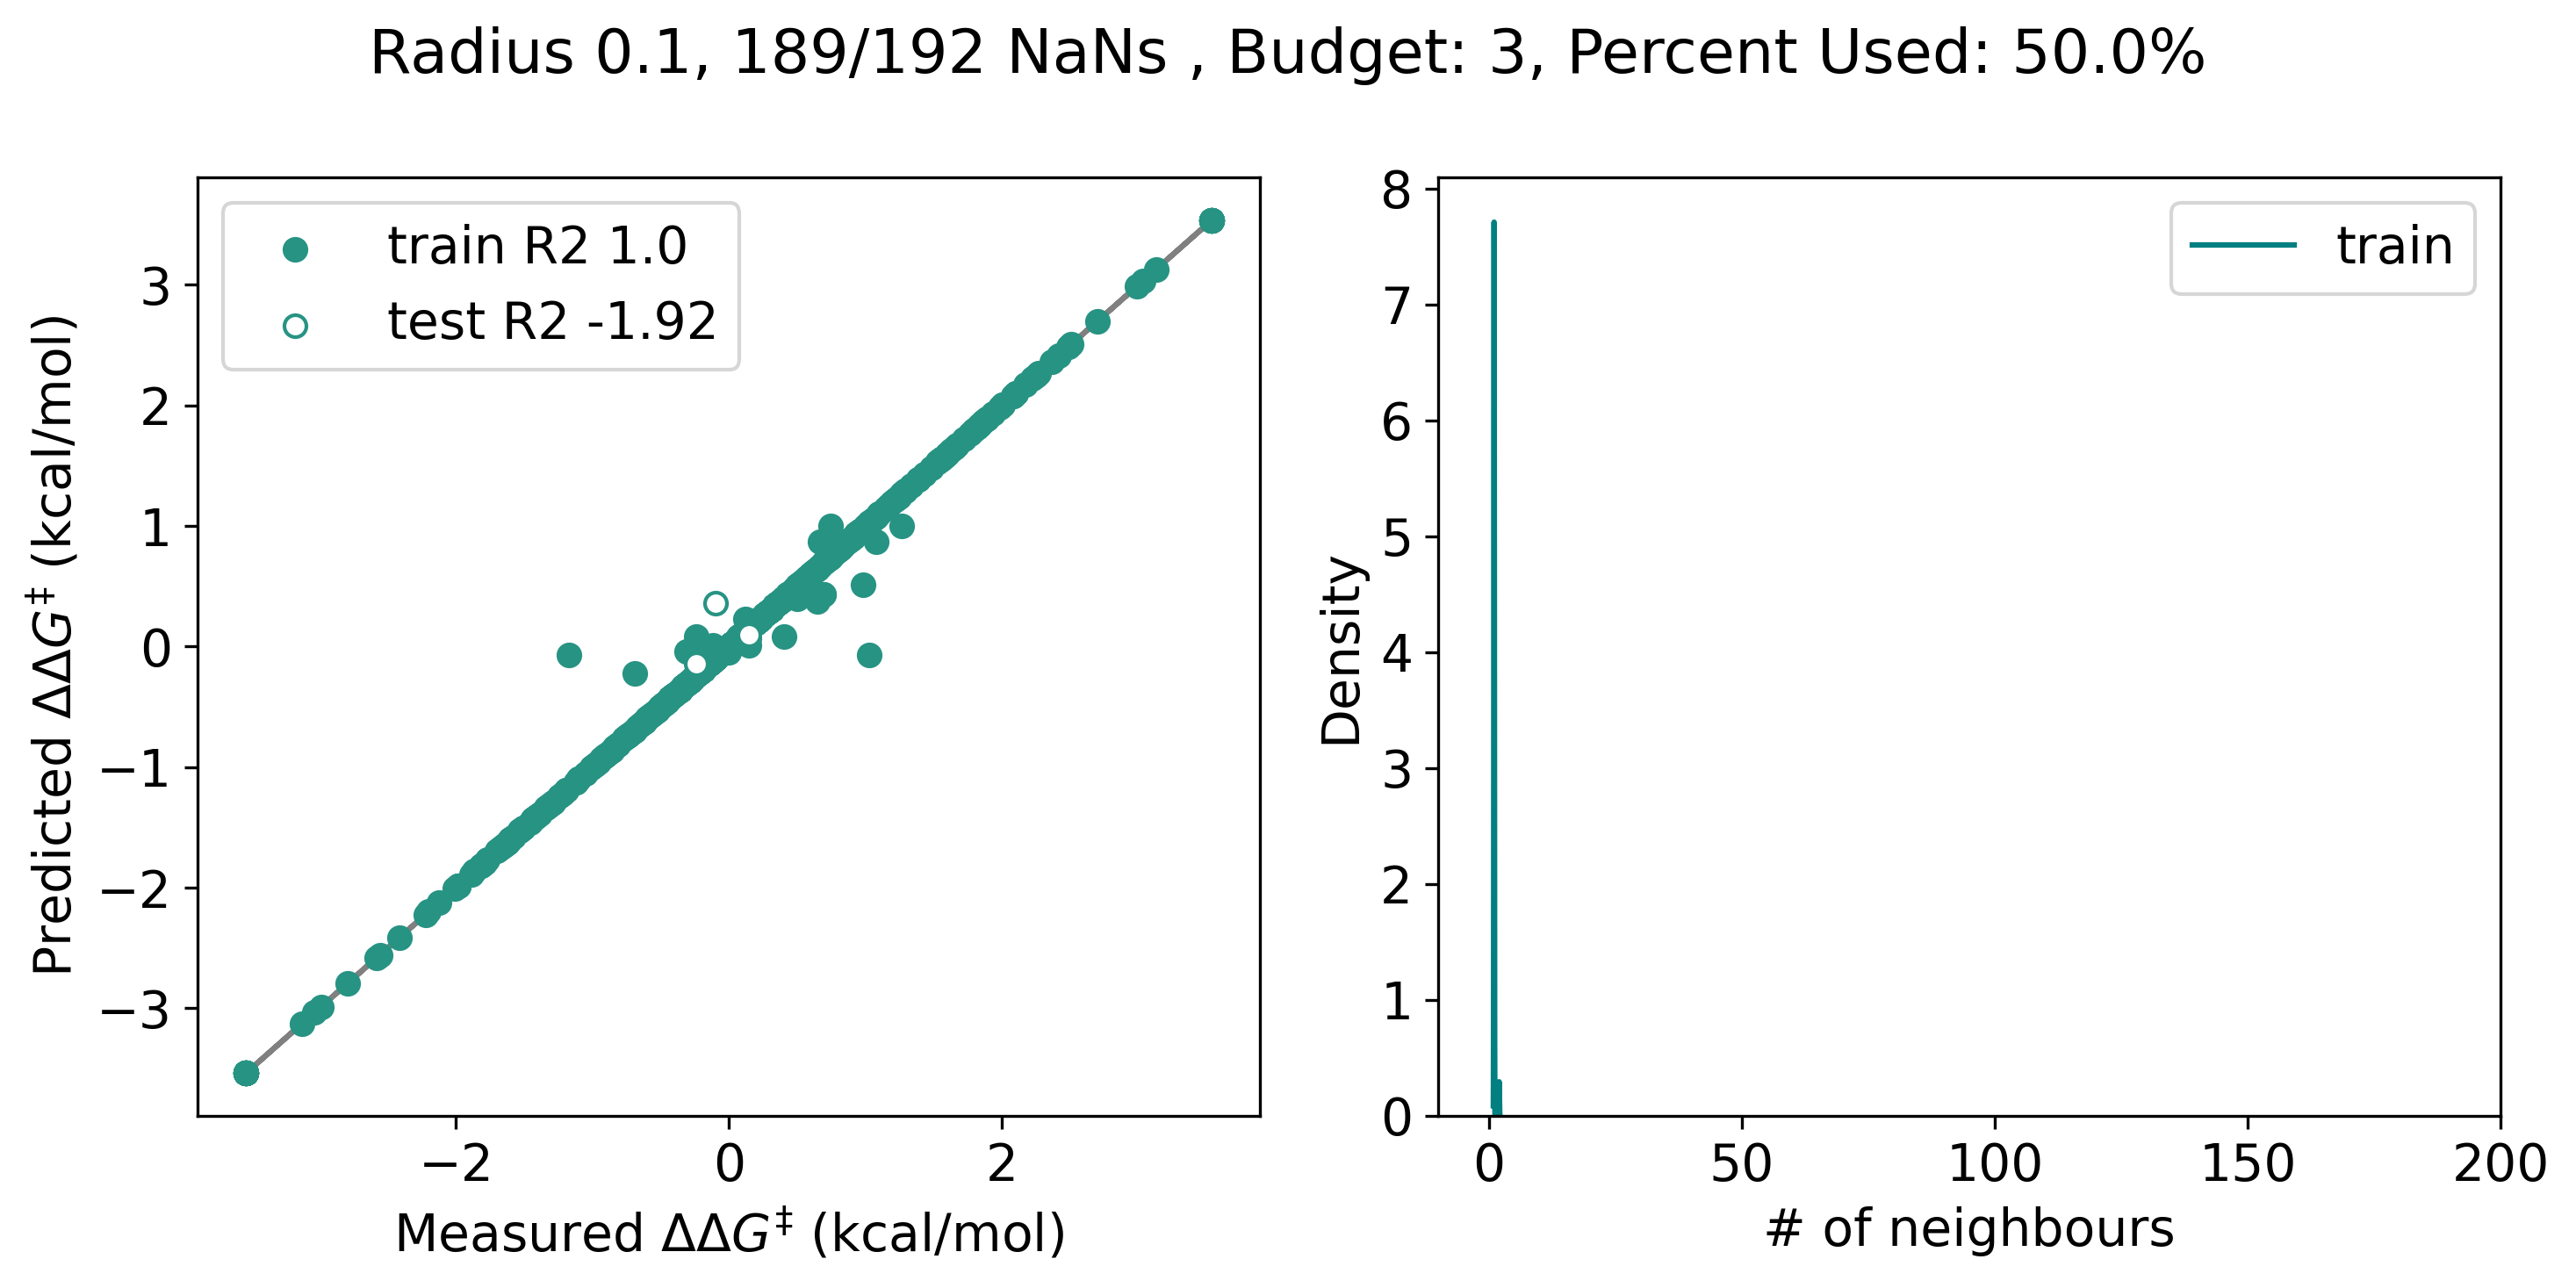

[-0.09560229  0.14340344 -0.23900574]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


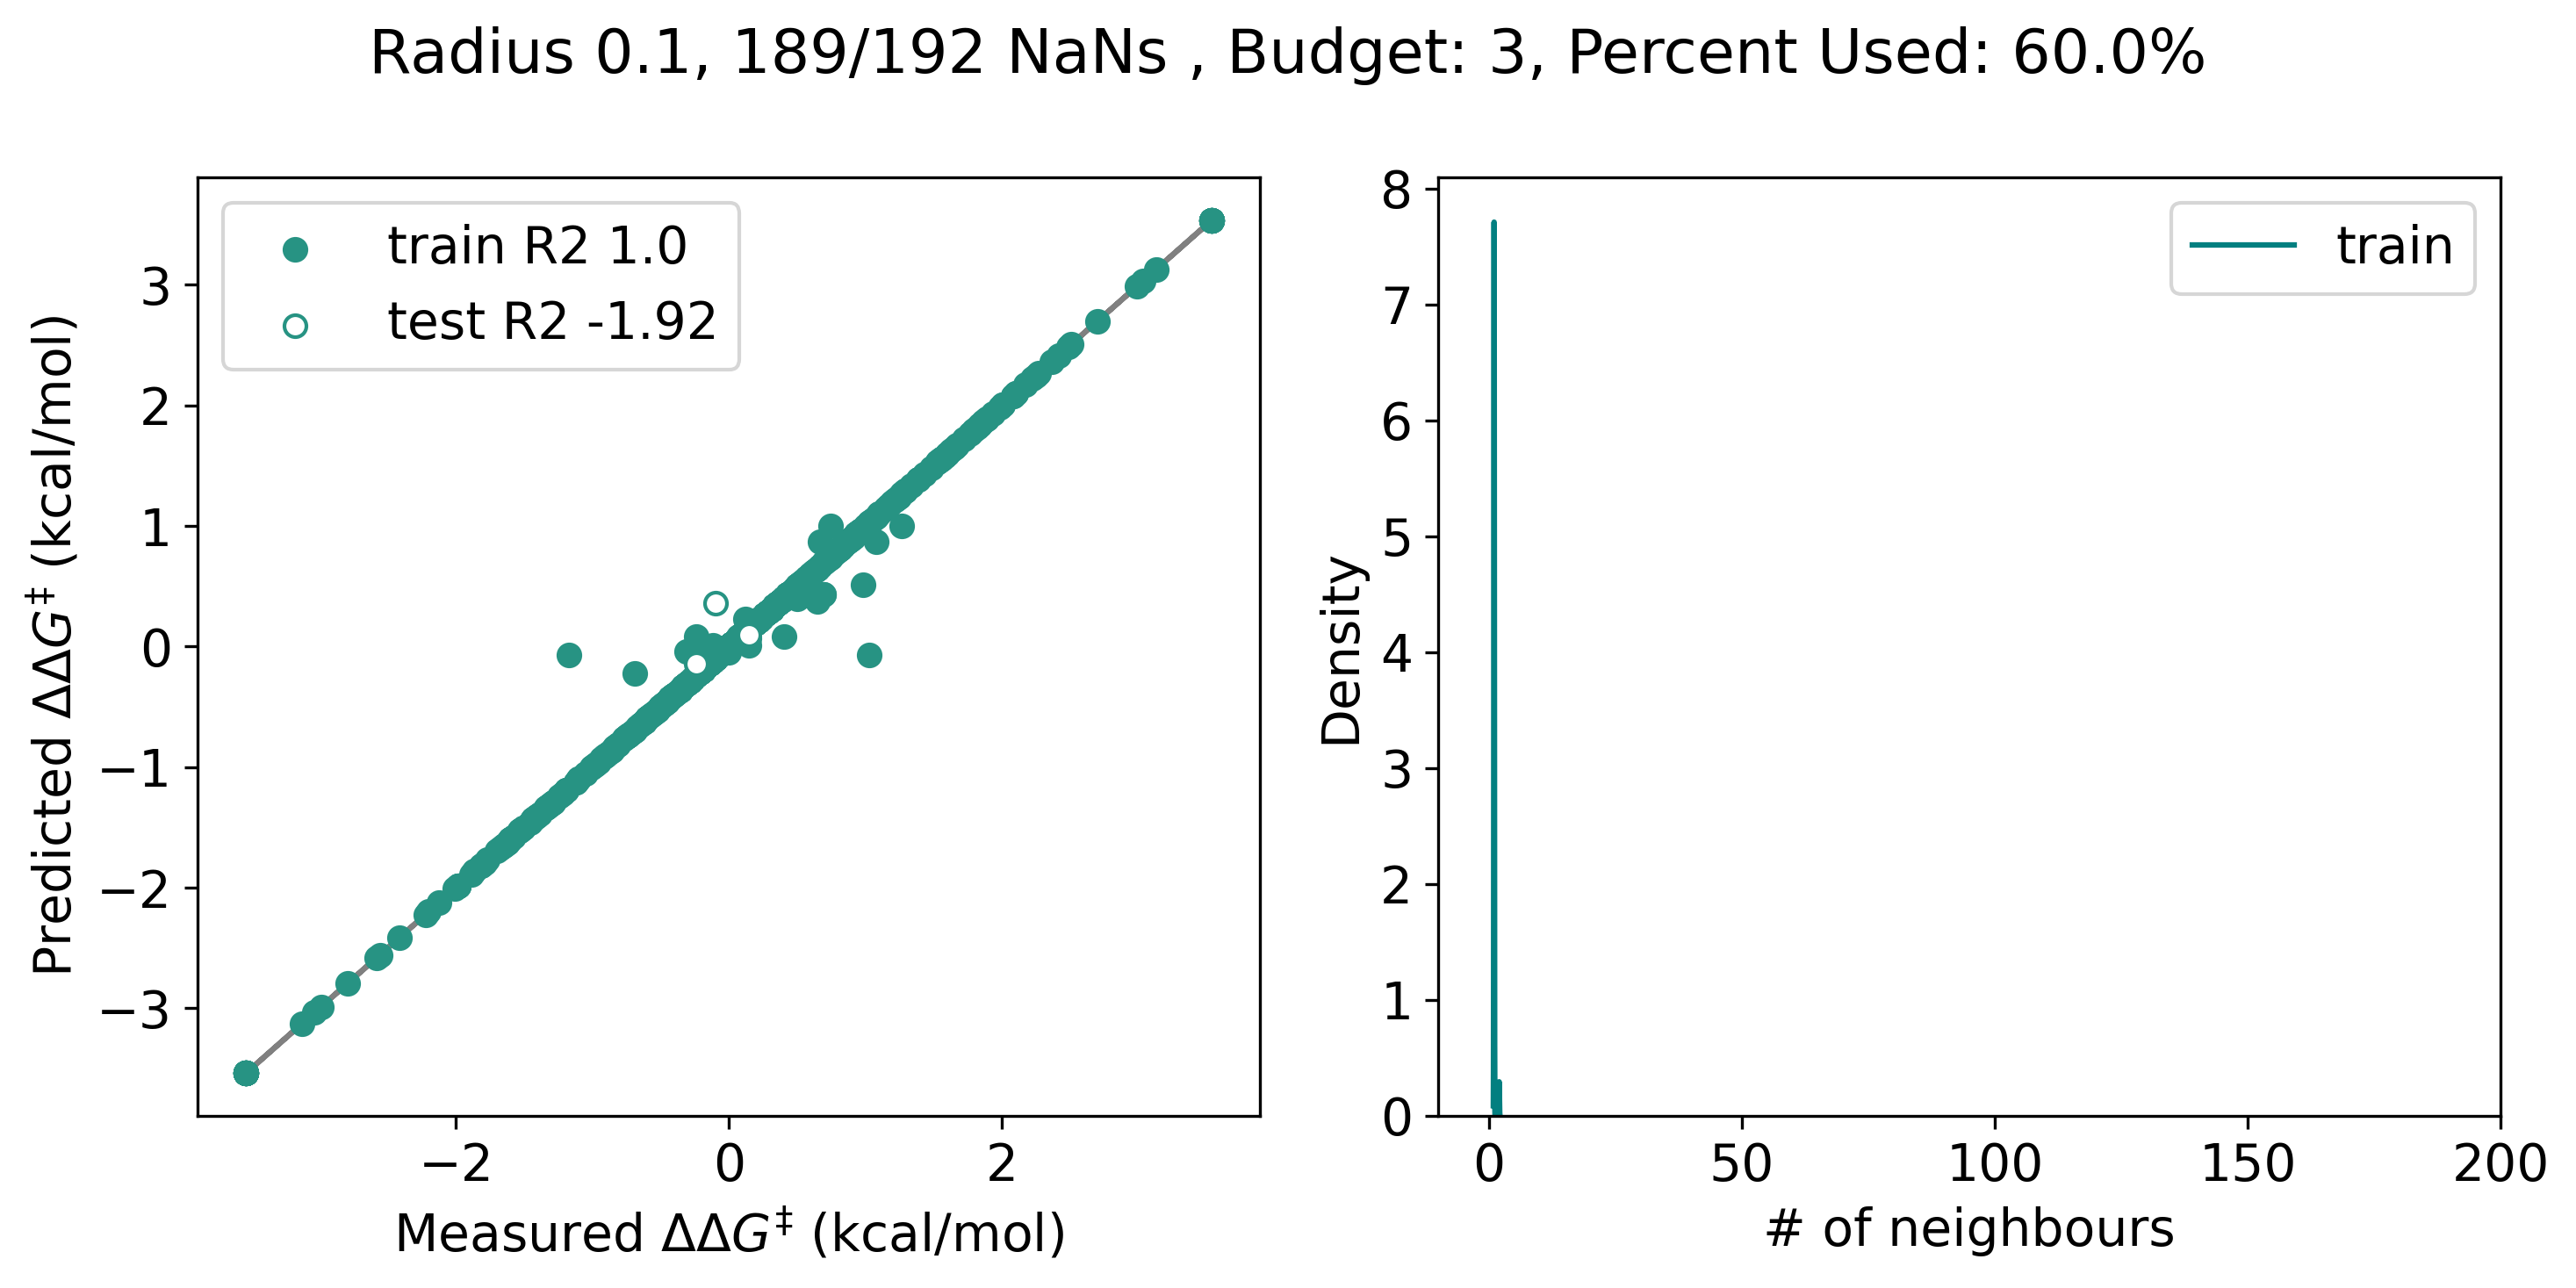

[-0.09560229  0.14340344 -0.23900574 -0.14340344]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


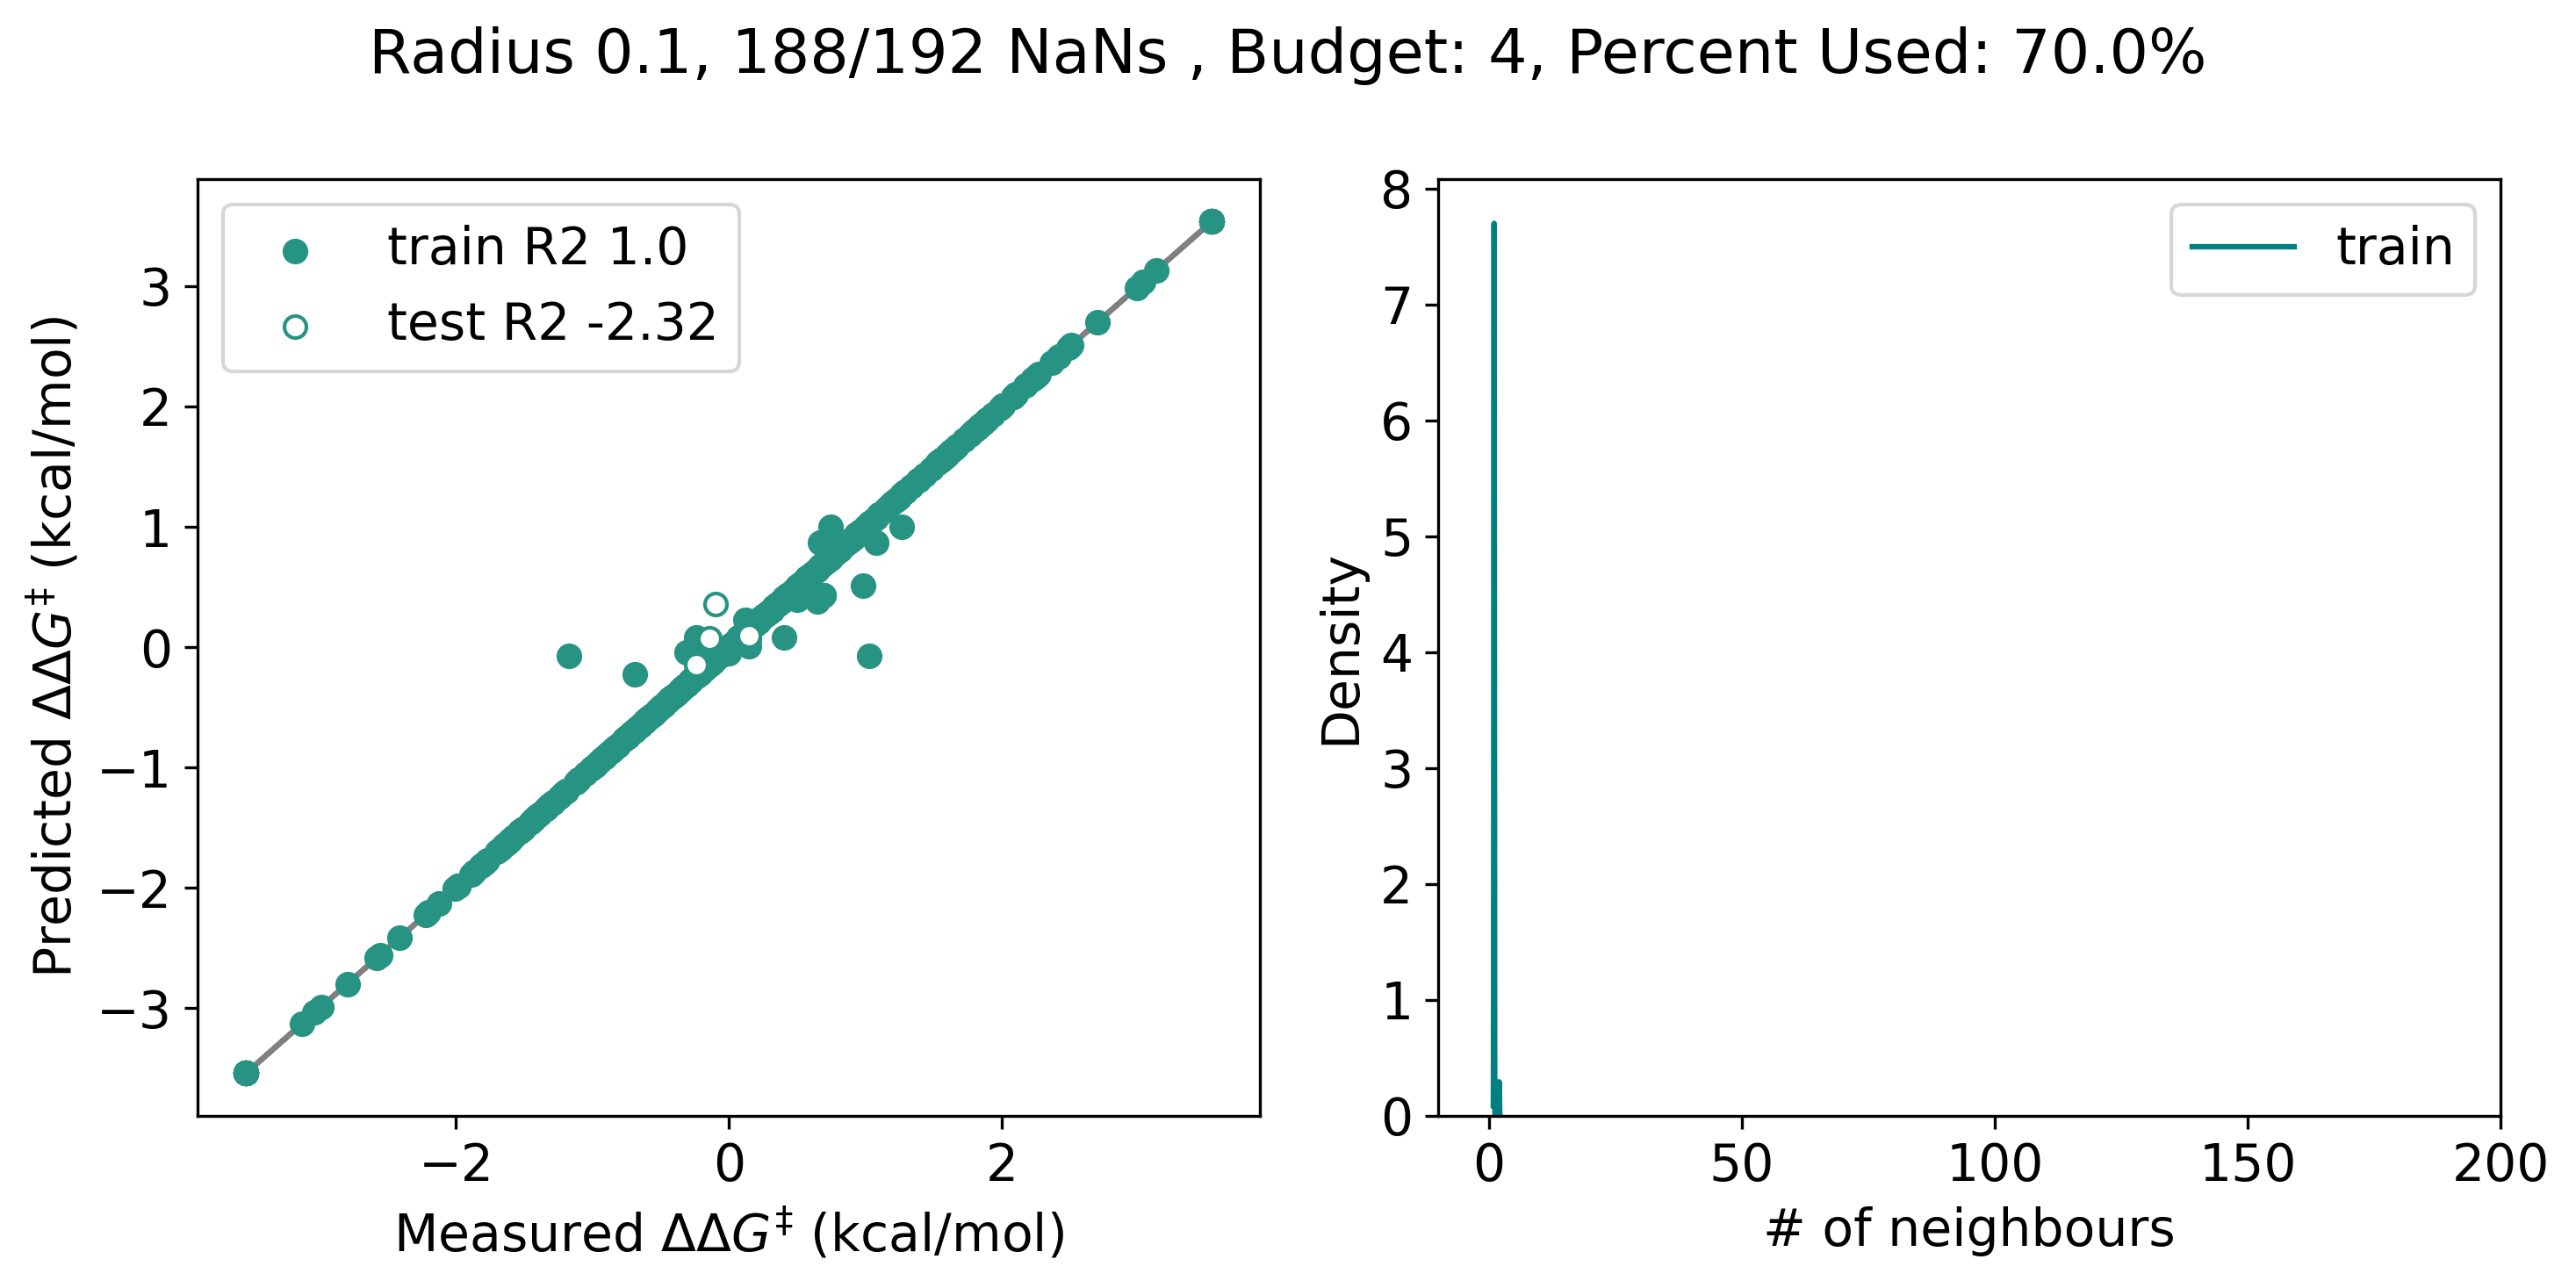

[-0.09560229  0.14340344 -0.23900574 -0.14340344]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


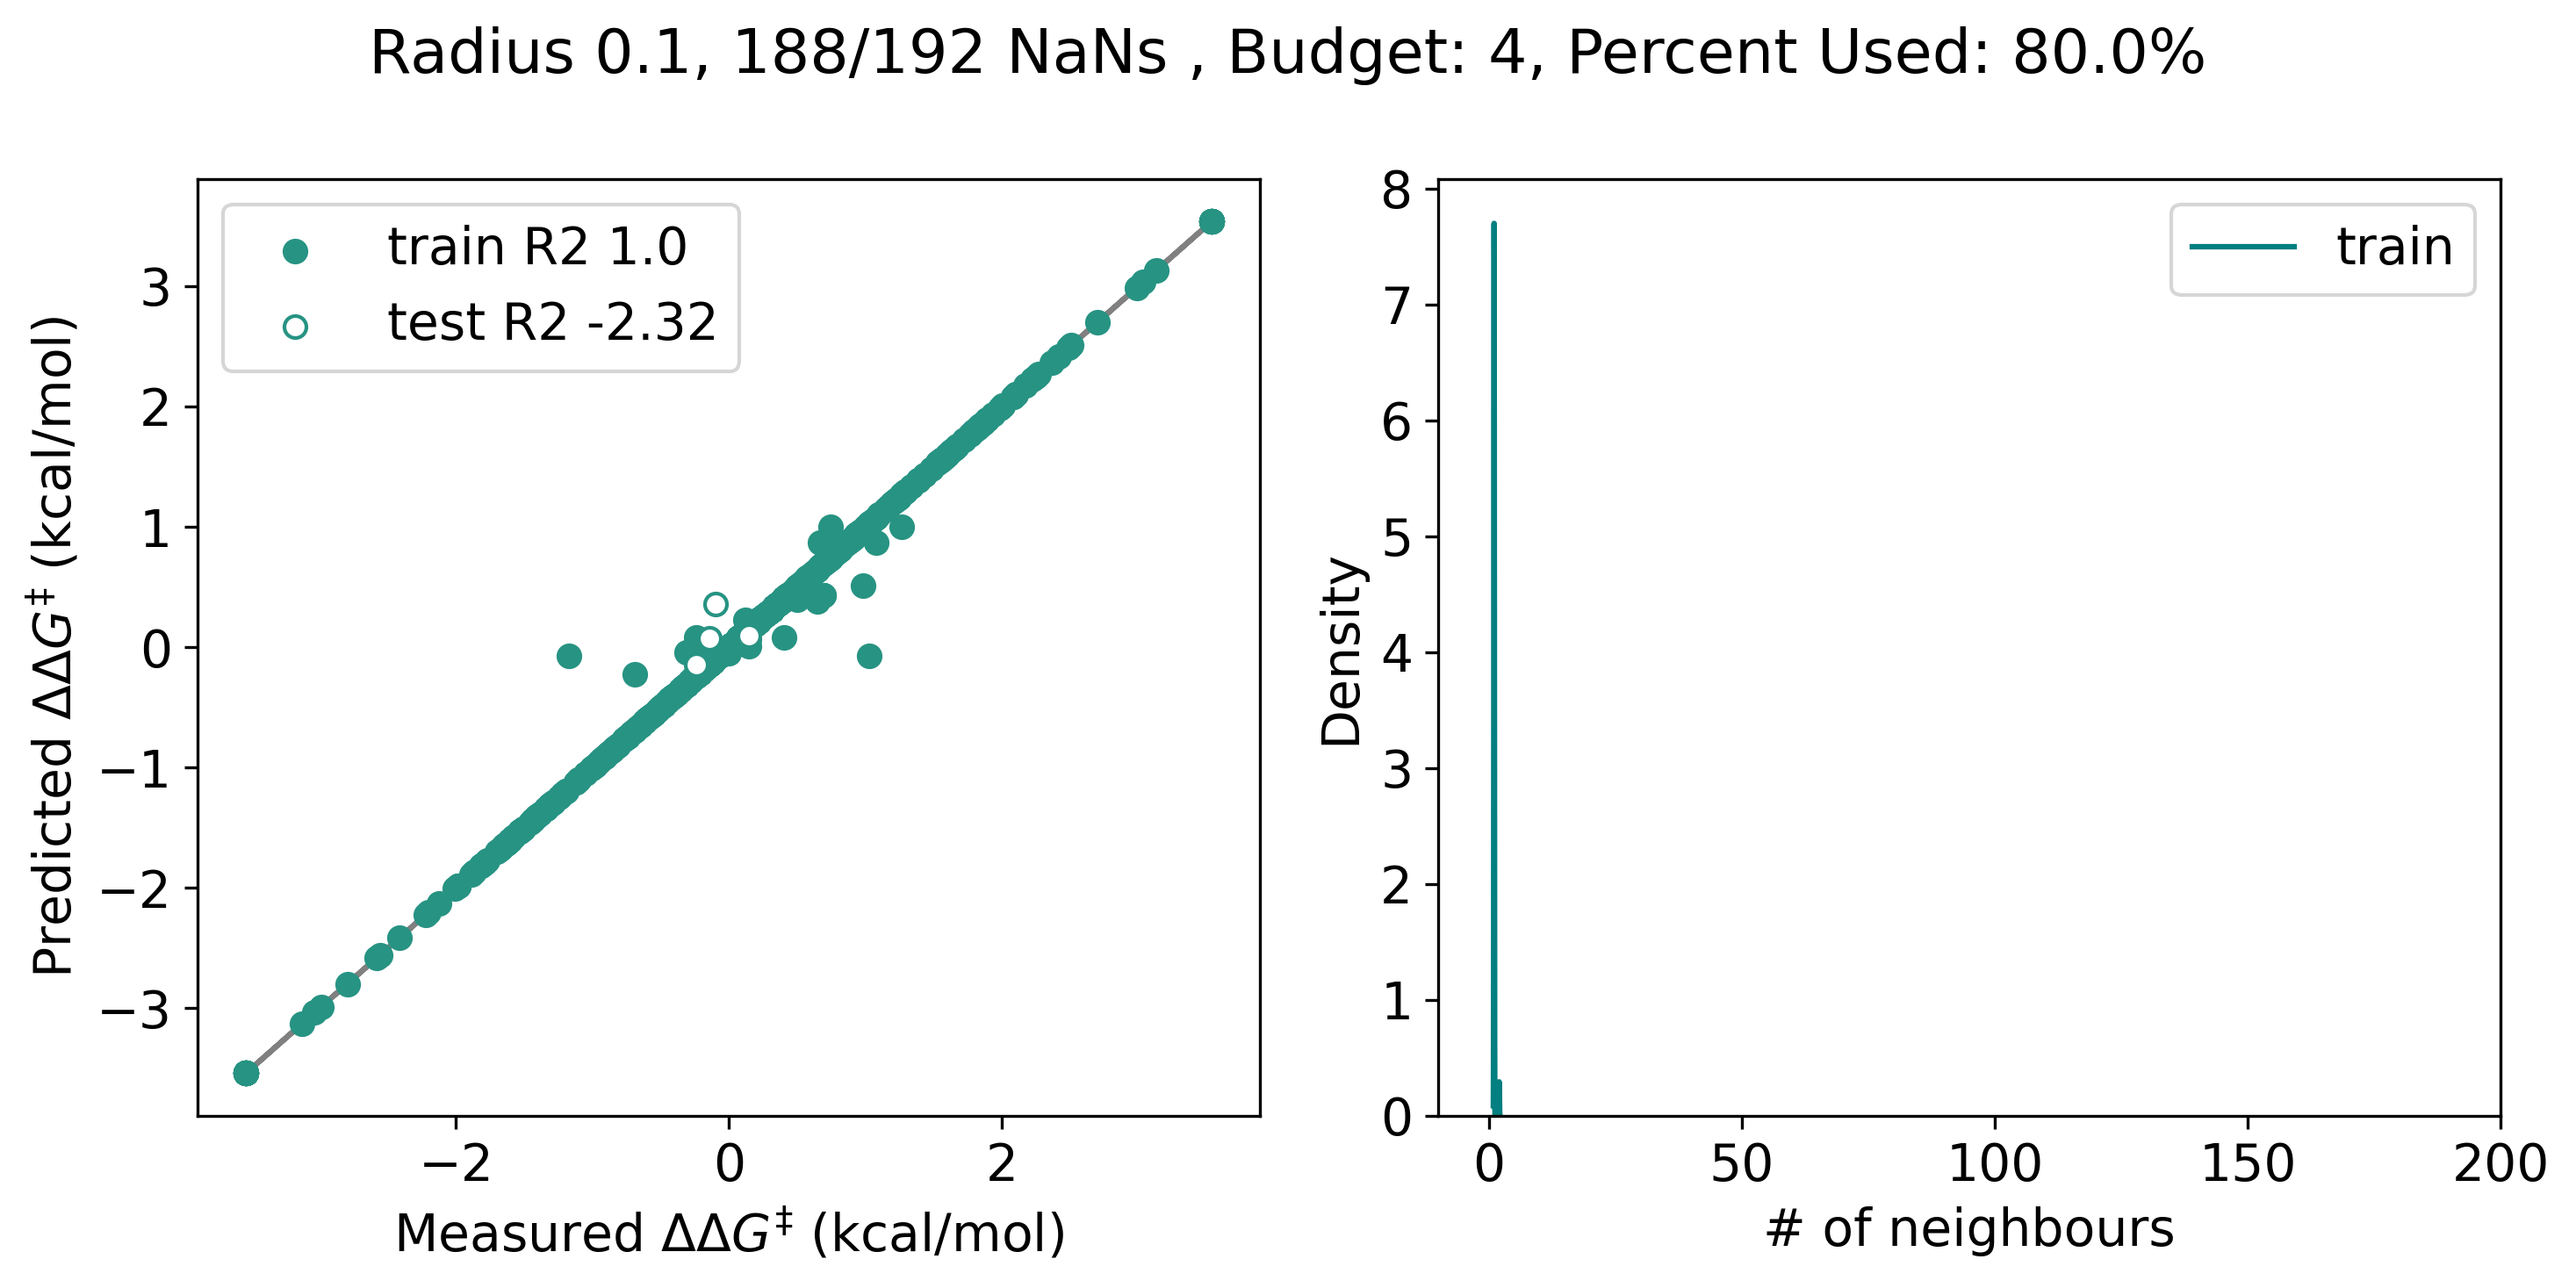

[-0.09560229  0.14340344  0.40630975 -0.23900574 -0.14340344]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


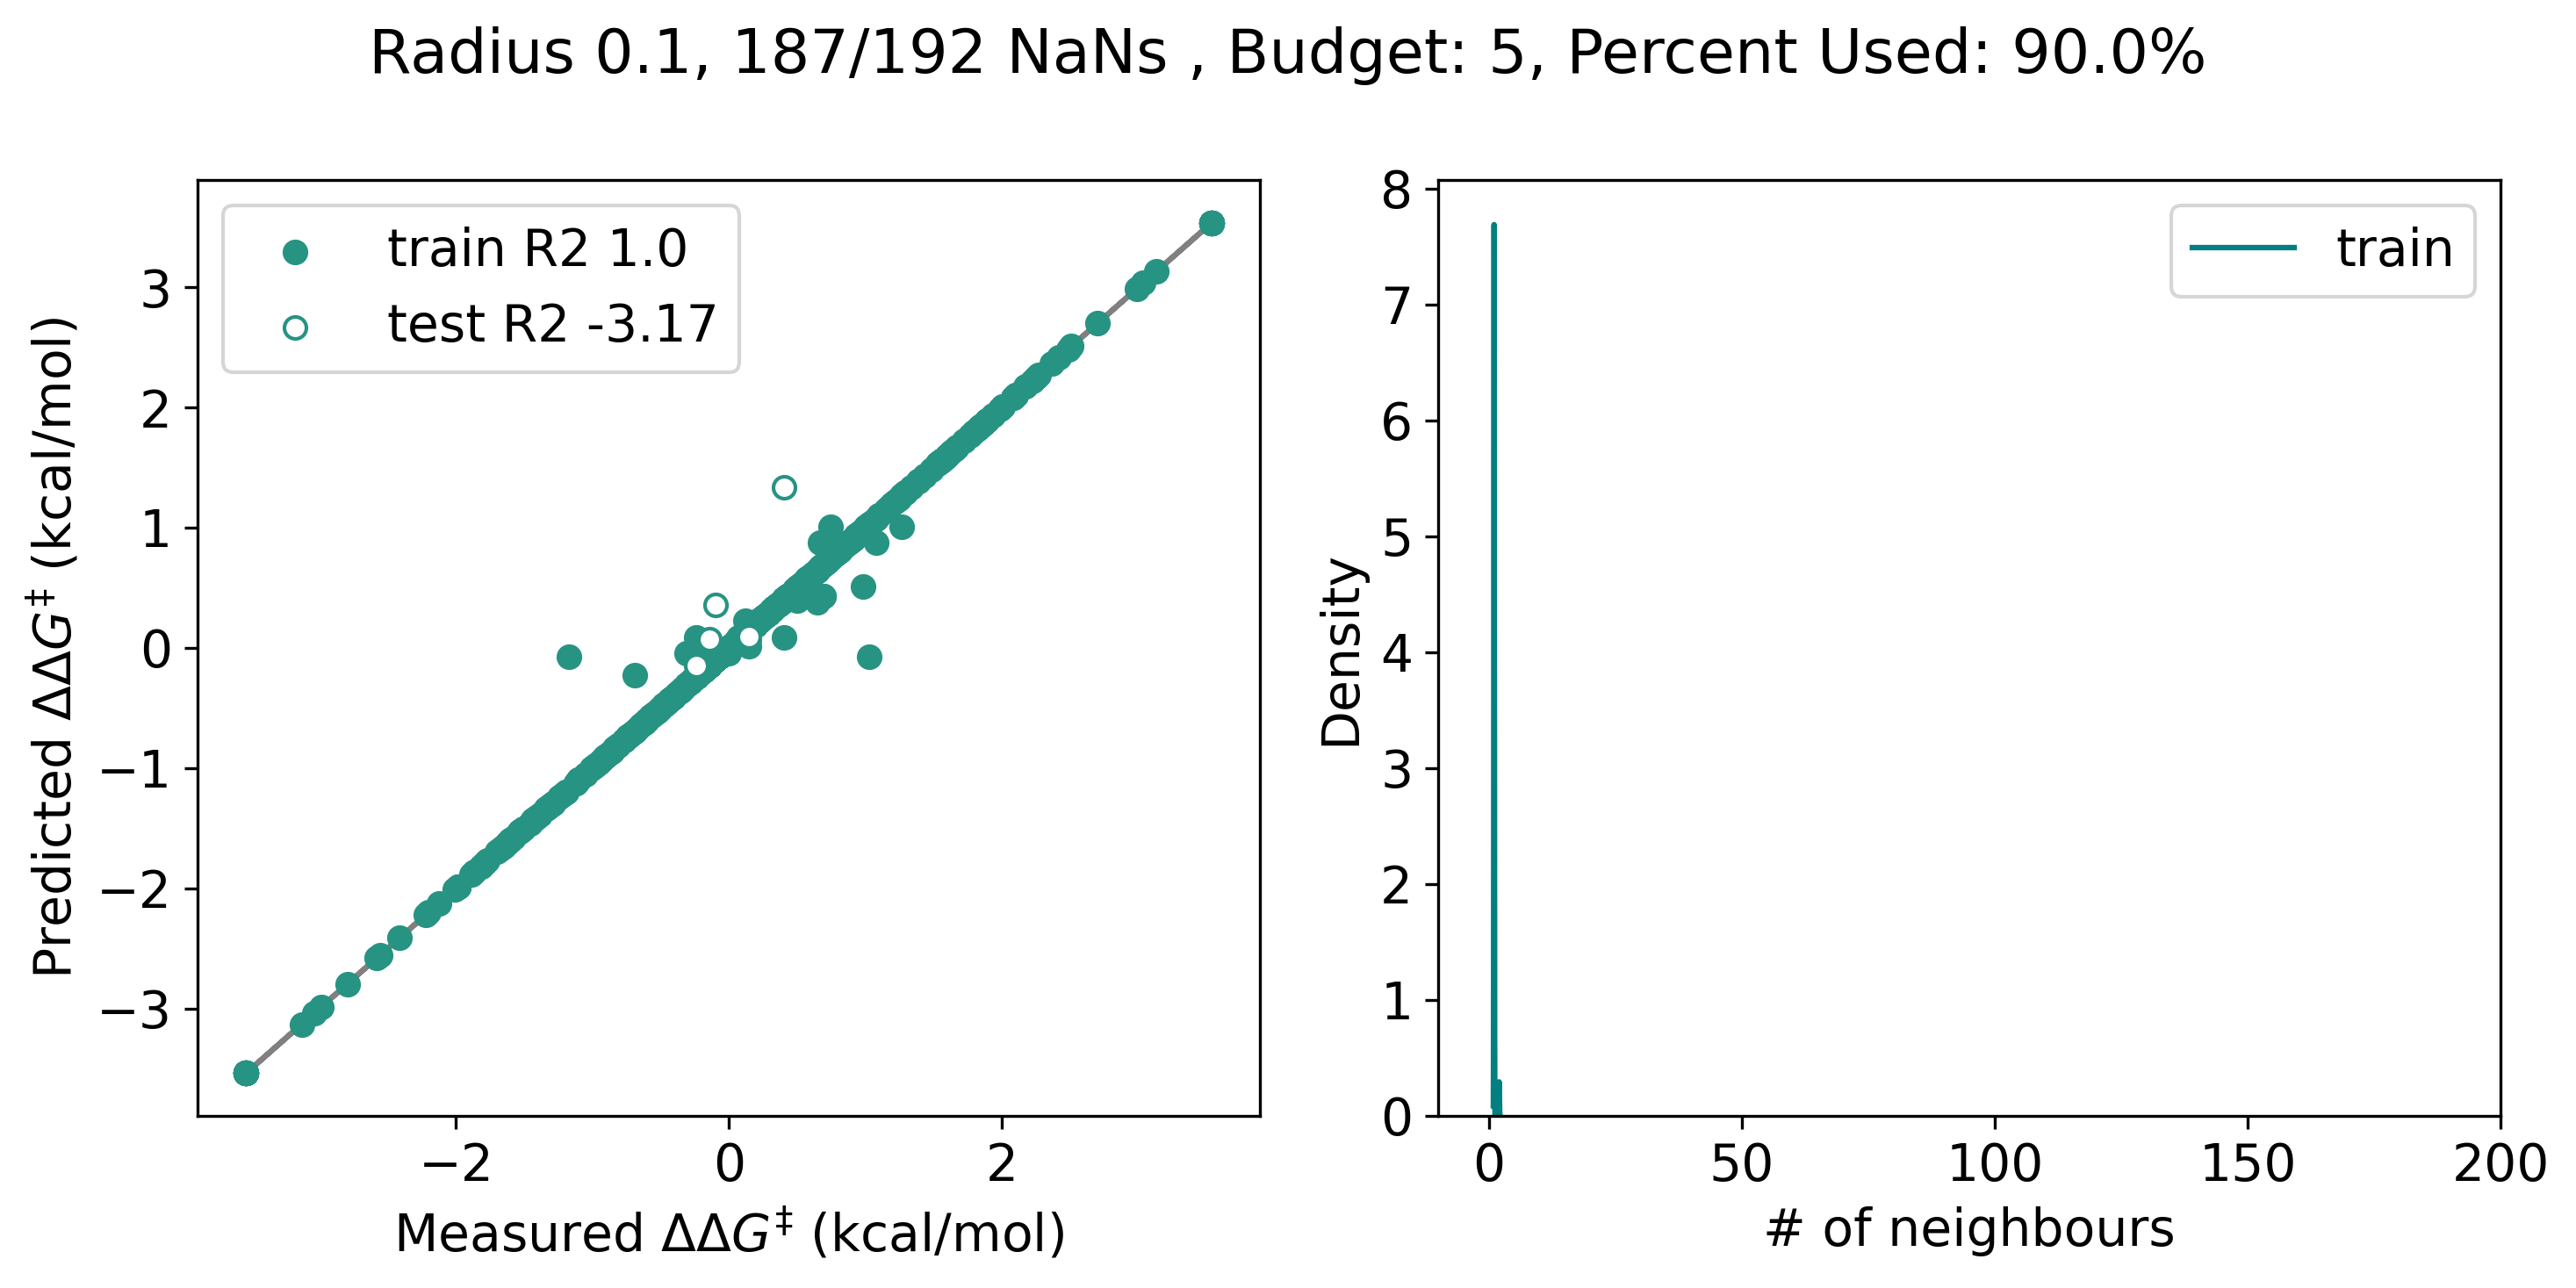

[ 0.21510516 -0.09560229  0.14340344  0.40630975 -0.23900574 -0.14340344]


/tmp/ipykernel_41860/2969131242.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  ax2 = sns.kdeplot(data=[[train_neighbours[x] for x in np.nonzero(train_neighbours)[0]], [test_neighbours[x] for x in np.nonzero(test_neighbours)[0]]], palette=[COLORA, COLORB])


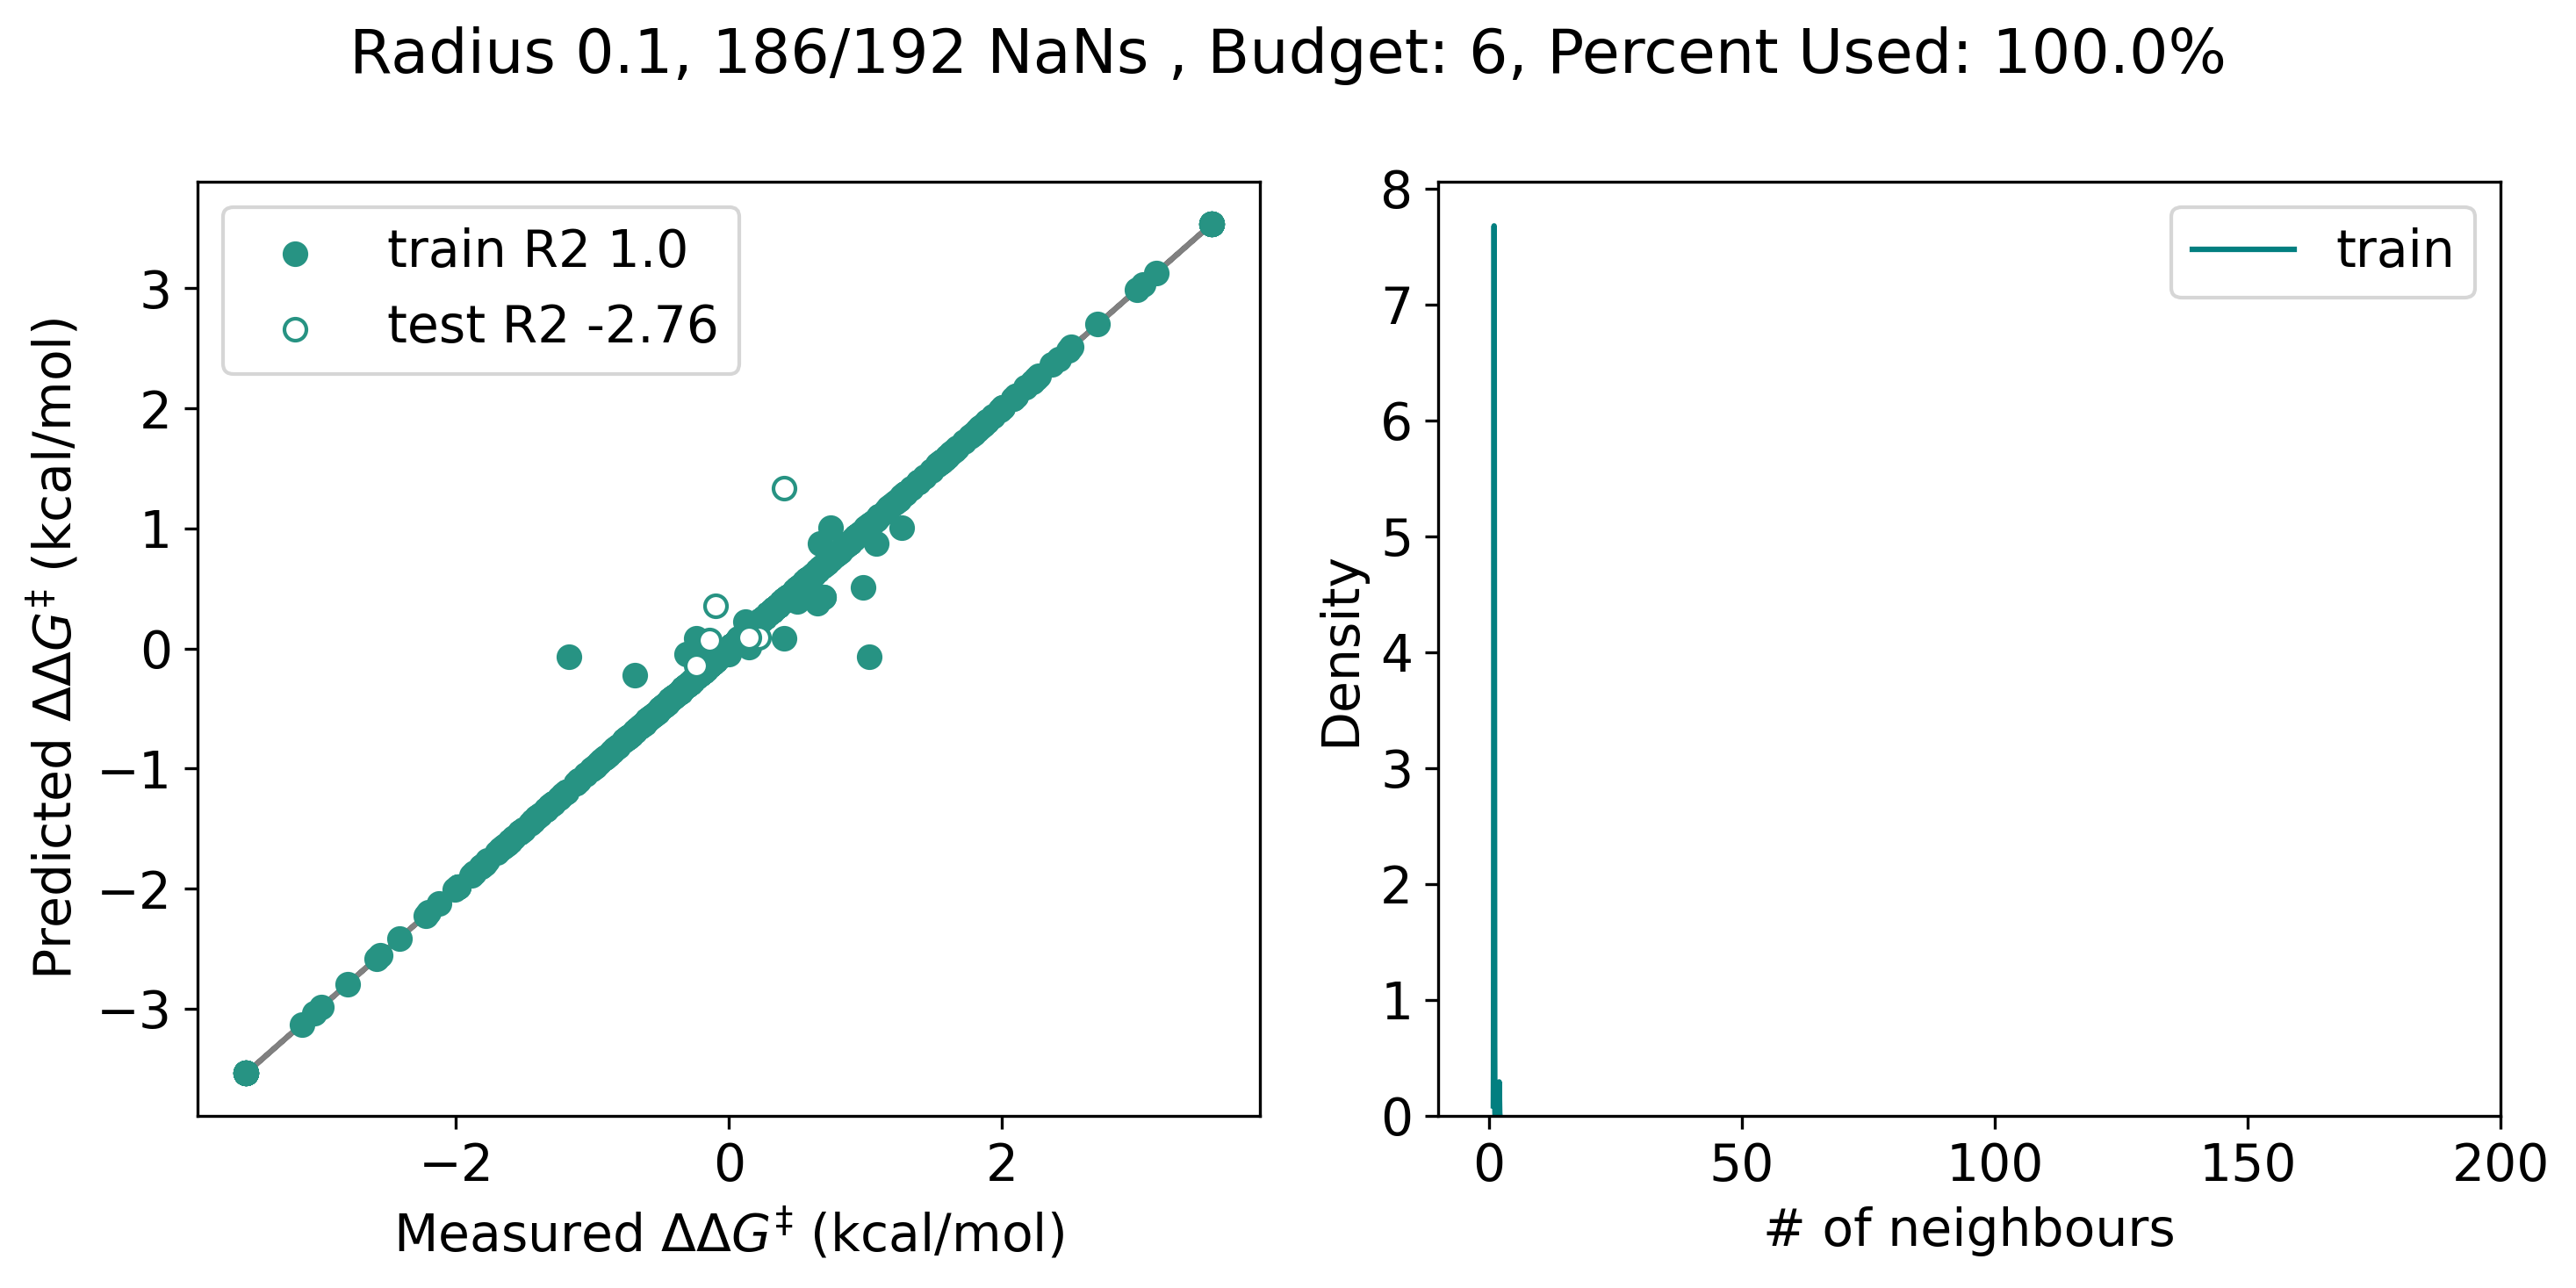

[0, 1, 1, 2, 3, 3, 4, 4, 5, 6]
[0, 1, 1, 2, 3, 3, 4, 4, 5, 6]
RARF MAE: (nan, 0.047801147227533564, 0.047801147227533564, 0.07170172084130016, 0.19917144678138946, 0.19917144678138946, 0.20315487571701724, 0.20315487571701724, 0.34894837476099394, 0.31070745697896723)
RARF R2: (nan, nan, nan, 0.8437500000000002, -1.9158163265306145, -1.9158163265306145, -2.323741007194248, -2.323741007194248, -3.172979797979786, -2.760299625468154)


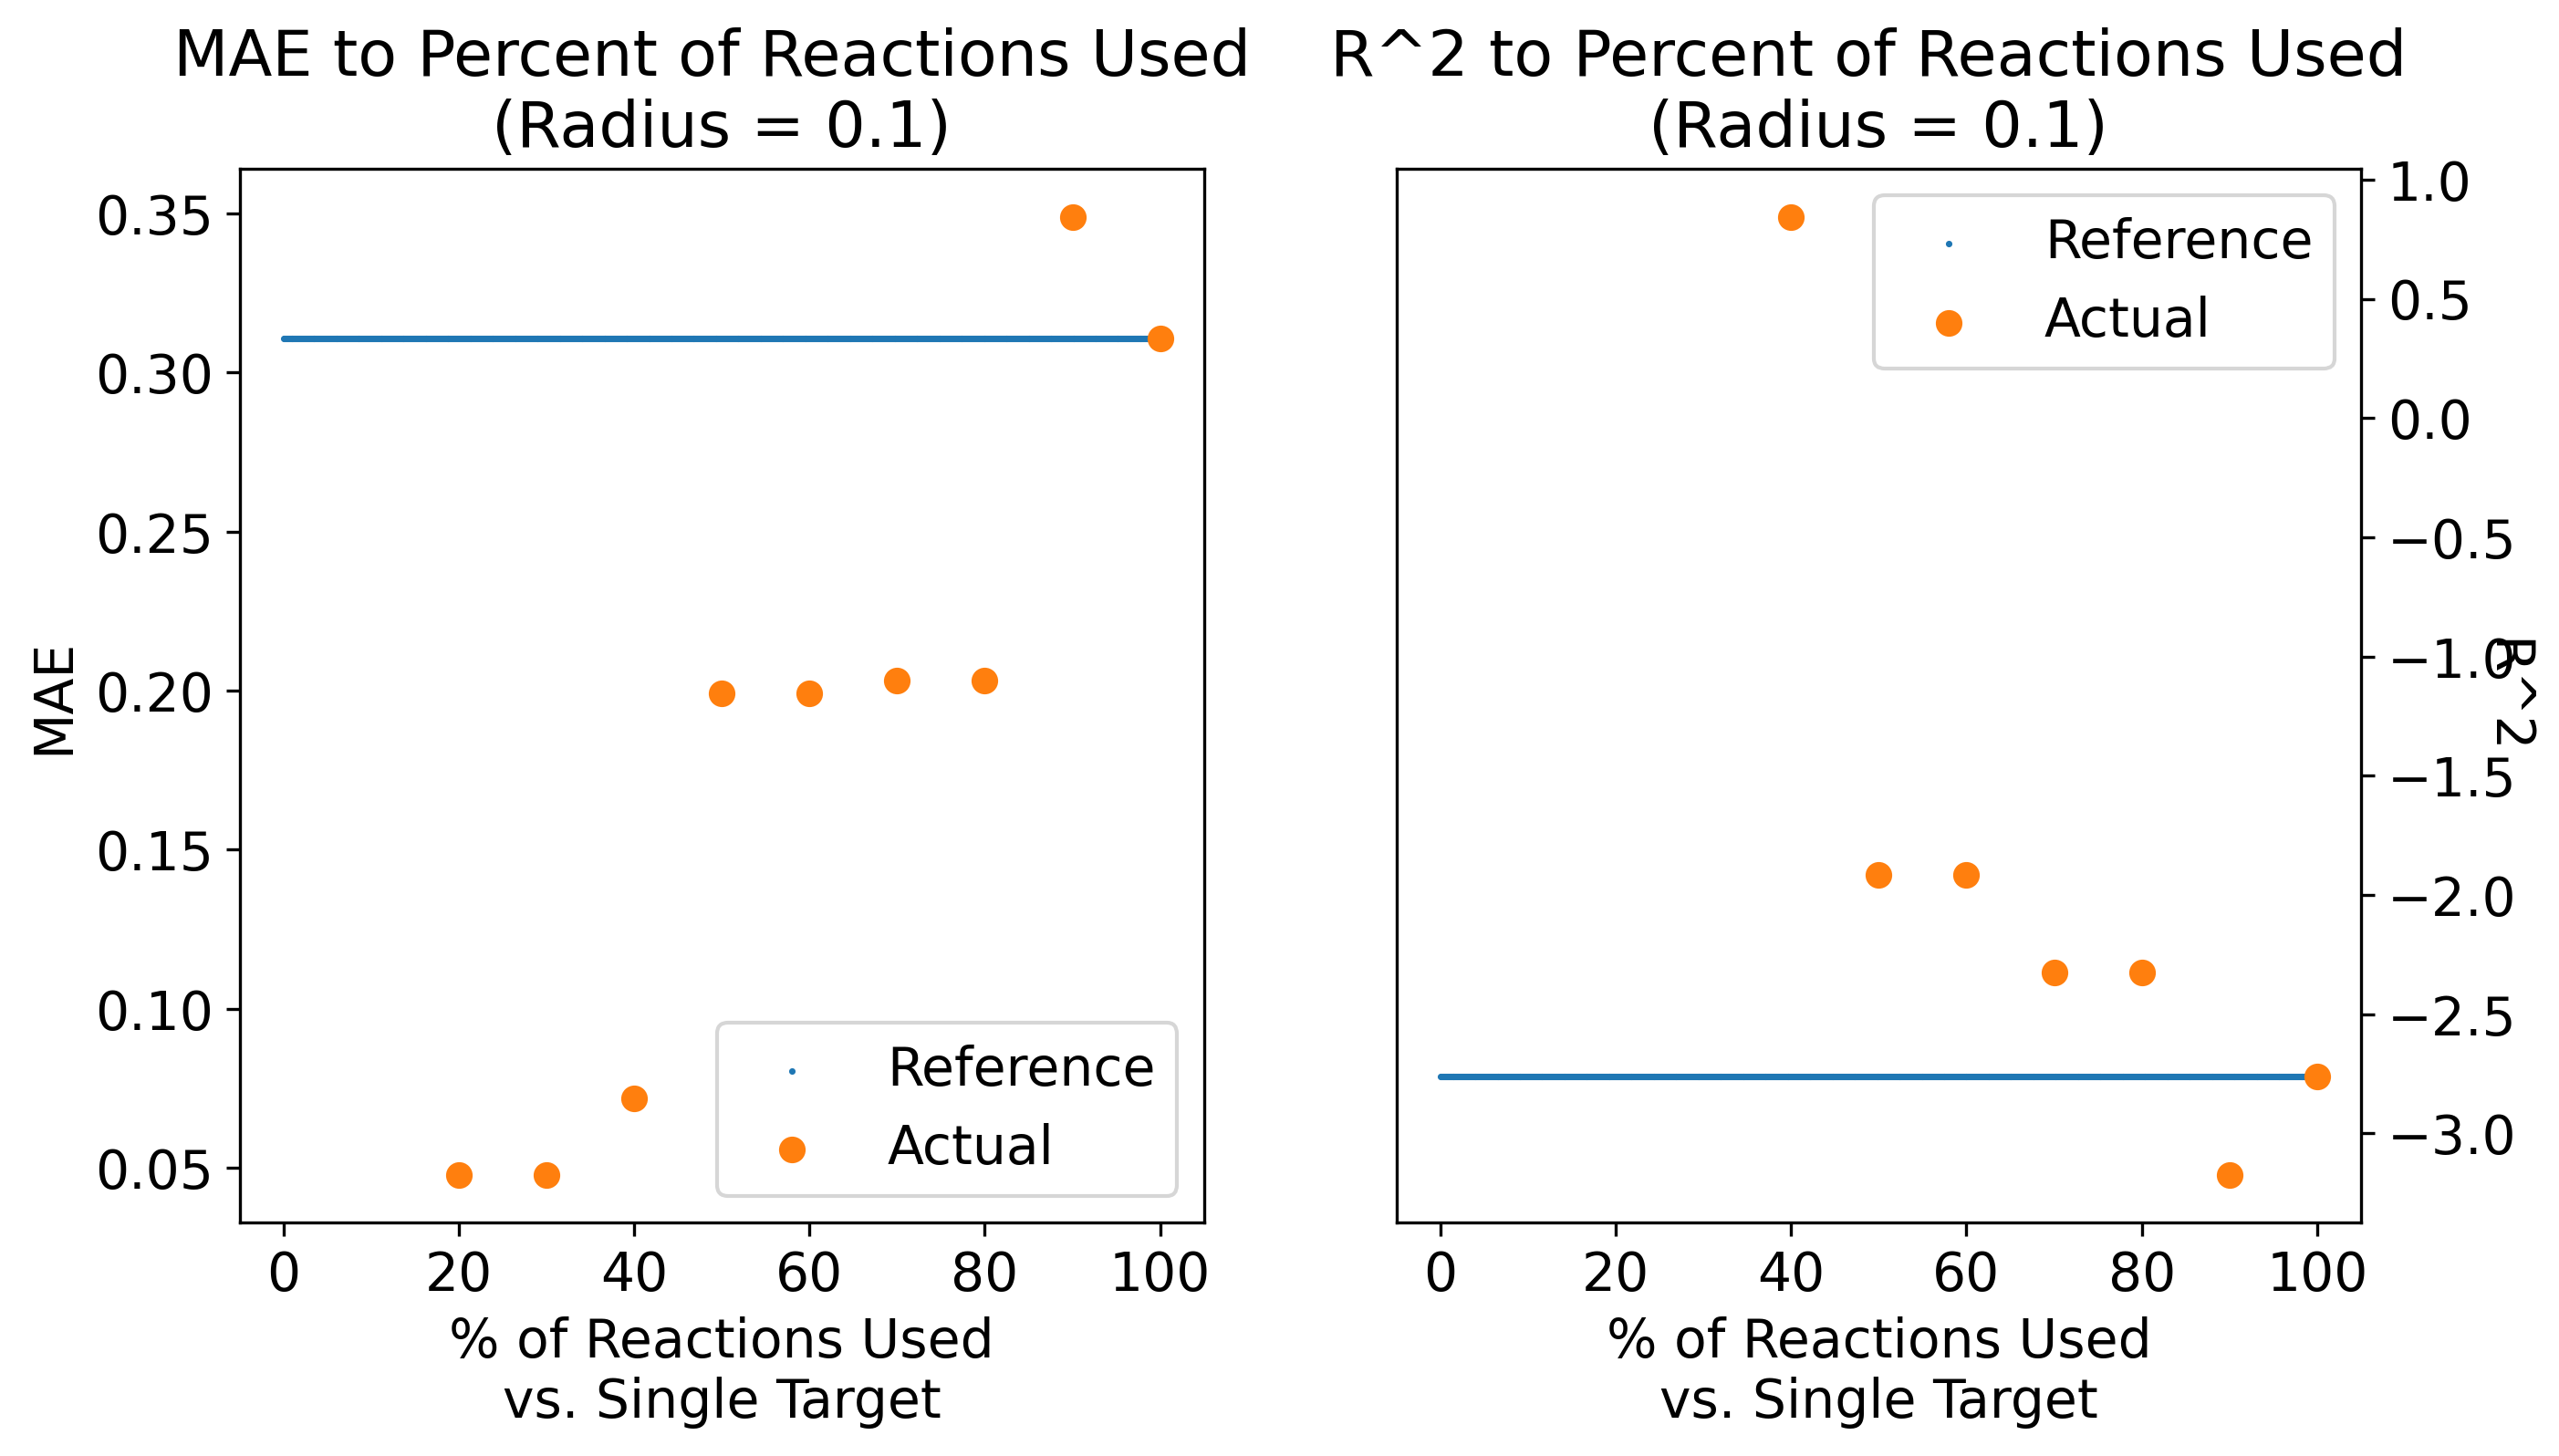

In [57]:

i = 0
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i], X_train, y_train, X_test, y_test)

In [ ]:
i = 1
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i], X_train, y_train, X_test, y_test)
#sorted neighbours is a little slow. Look at that later.

In [ ]:
i = 2
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i], X_train, y_train, X_test, y_test)

In [ ]:
i = 3
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i], X_train, y_train, X_test, y_test)

In [ ]:
i = 4
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i], X_train, y_train, X_test, y_test)

In [ ]:
i = 5
run_MT(cutoffs[i], num_reactions[i], RaRF_mae[i], test_r2s[i], X_train, y_train, X_test, y_test)